## Prologue

Run these cells prior to running any cell below, in order for the script and models to function in a proper way.

In [1]:
# Install libraries

import os
import sys
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.lines as lines

from sklearn.preprocessing import MinMaxScaler, PowerTransformer, StandardScaler
from IPython.display import display, HTML

# Ignore warnings 
pd.options.mode.chained_assignment = None

# Set figure size
plt.rcParams['figure.figsize'] = [25, 10]

In [2]:
# Create universally (i.e. across various operating systems) recognized paths

notebook_path = os.path.abspath('Resolution 3650.ipynb')          # Jupyter notebook path
TCDF_path = os.path.join(os.path.dirname(notebook_path), 'TCDF')       # TCDF folder path
TCDFdata_path = os.path.join(TCDF_path, 'data')                        # TCDF/data folder path
EBT_path = os.path.join(os.path.dirname(notebook_path), 'EBT Data')    # EBT folder path
DefaultCod_path = os.path.join(EBT_path, 'Modified Default Cod')       # EBT/Modified Default Cod folder path
Cod_path = os.path.join(DefaultCod_path, 'Modified Default.out')       # EBT/Modified Default Cod/Modified Default.out file path

In [3]:
# Install conda- and pip packages in the current Jupyter kernel

!conda install -c anaconda tensorflow --y
!pip3 install torch torchvision torchaudio
!{sys.executable} -m pip install torchvision

Solving environment: ...working... done

# All requested packages already installed.



In [4]:
# Load clean data from EBT tool into DataFrame
file_path = os.path.join(TCDFdata_path, 'EBT_dataset.csv')
ebt = pd.read_csv(file_path, delimiter = ',', header = 0)

# Define labels
labels = ['Time (year)',
          'Rs', 'Rj', 'Ra',                               # Shared resources biomass
          'Sj', 'Sa', 'Sb',                               # Sprat stages biomass
          'Cj', 'Ca', 'Cb',                               # Cod stages biomass
          'Fc']
biomass_labels = ['Rs', 'Rj', 'Ra',                       # Shared resources biomass
                  'Sj', 'Sa', 'Sb',                       # Sprat stages biomass
                  'Cj', 'Ca', 'Cb',                       # Cod stages biomass
                  'Fc']

ebt = ebt[labels]

In [5]:
# Define function for visualisation of scaled data 

def plot_data(data, years): 
    """This function plots selected data within given timeframe [years] for the triptrophic community. 
    Provided data should be a DataFrame with at least columns [Cj, Ca, Cb, Sj, Sa, Sb, Rj, Rs, Ra].
    The years argument is given as a list with two numbers between 0 and 100."""
    
    # Select data to be visualized
    cod = data[['Cj', 'Ca', 'Cb']]
    sprat = data[['Sj', 'Sa', 'Sb']]
    resource = data[['Rj', 'Rs', 'Ra']]
    data['Time'] = np.linspace(years[0], years[1], len(data))
    time = data['Time']

    # Set subplot figure defaults
    fig, [cod_plt, sprat_plt, resource_plt] = plt.subplots(3, 1, sharex = True)
    fig.subplots_adjust(hspace = 0)
    fig.suptitle('Cod-sprat-resource dynamics {start}-{stop} years (scaled)'.format(start=years[0],stop=years[1]))

    # Set labels for shared x-axis and individual y-axes
    cod_plt.set(ylabel = 'Cod biomass')
    sprat_plt.set(ylabel = 'Sprat biomass')
    resource_plt.set(ylabel = 'Resource biomass')
    plt.xlabel('Time (years)')

    # Visualize data
    cod_plt.plot(time, cod)
    sprat_plt.plot(time, sprat)
    resource_plt.plot(time, resource)

    # Add legends
    cod_plt.legend(['Cj', 'Ca', 'Cb'], loc = 'center left')
    sprat_plt.legend(['Sj', 'Sa', 'Sb'], loc = 'center left')
    resource_plt.legend(['Rj', 'Rs', 'Ra'], loc = 'center left')

    # Remove Time column
    data.drop(['Time'], axis = 1, inplace = True)

In [6]:
# Define function that preprocesses (i.e. scale min-max) and select data from desired timeframe 

def select_data(data, start, stop, preprocessor='min-max'):        
    """This function preprocesses selected data.
    Three processing methods can be used (min-max, standard, power) - min-max default.
    Selection of data timeframe is specified with the [start] and [stop] arguments."""

    # Select information of datapoints
    selected_data = data[(data['Time (year)'] >= start) & (data['Time (year)'] <= stop)]

    # Normalize data
    # Min-max normalization
    if preprocessor == 'min-max':
        scaler = MinMaxScaler()
    # Power transformer normalization
    elif preprocessor == 'power':
        scaler = PowerTransformer()  
    # Standard normalization
    elif preprocessor == 'standard':
        scaler = StandardScaler()
    
    scaled = scaler.fit_transform(selected_data[biomass_labels])
    
    # Write scaled data to DataFrame
    processed_data = pd.DataFrame(scaled, columns = biomass_labels)

    # Check the scaled DataFrame
    display(processed_data.head(-10))
    # Plot scaled data 
    plot_data(processed_data, [start,stop])
    
    return processed_data

In [7]:
# Define function to plot the model's loss or accuracy (i.e. performance) after running 

def plot_performance(losses_or_accuracy):
    """This function plots the losses for each trained variable for the TCDF model.
    Takes a dictionary with either losses or accuracy for each variable as input"""
    
    # Preallocate plots in subplots
    fig, axs = plt.subplots(3, 3, sharex = True)
    for ax in axs.flat:
        ax.set(xlabel='Epochs', ylabel='Performance measure')

    # Iterate over each key in dictionary
    keys = list(losses_or_accuracy.keys())
    
    # Plot every variable in different subplot
    axs[0, 0].plot(np.arange(len(losses_or_accuracy[keys[0]])), losses_or_accuracy[keys[0]])
    axs[0, 0].set_title('Performance Rs')
    axs[0, 1].plot(np.arange(len(losses_or_accuracy[keys[1]])), losses_or_accuracy[keys[1]])
    axs[0, 1].set_title('Performance Rj')
    axs[0, 2].plot(np.arange(len(losses_or_accuracy[keys[2]])), losses_or_accuracy[keys[2]])
    axs[0, 2].set_title('Performance Ra')
    axs[1, 0].plot(np.arange(len(losses_or_accuracy[keys[3]])), losses_or_accuracy[keys[3]])
    axs[1, 0].set_title('Performance Sj')
    axs[1, 1].plot(np.arange(len(losses_or_accuracy[keys[4]])), losses_or_accuracy[keys[4]])
    axs[1, 1].set_title('Performance Sa')
    axs[1, 2].plot(np.arange(len(losses_or_accuracy[keys[5]])), losses_or_accuracy[keys[5]])
    axs[1, 2].set_title('Performance Sb')
    axs[2, 0].plot(np.arange(len(losses_or_accuracy[keys[6]])), losses_or_accuracy[keys[6]])
    axs[2, 0].set_title('Performance Cj')
    axs[2, 1].plot(np.arange(len(losses_or_accuracy[keys[7]])), losses_or_accuracy[keys[7]])
    axs[2, 1].set_title('Performance Ca')
    axs[2, 2].plot(np.arange(len(losses_or_accuracy[keys[8]])), losses_or_accuracy[keys[8]])
    axs[2, 2].set_title('Performance Cb')


In [8]:
# Define function for adding white noise

def noise(signal, snr):
    """This function adds white Gaussian noise to a signal.
    Noise is added to existing signal and created by a desired signal-to-noise ratio (SNR).
    Function returns the original signal with added noise by the given SNR."""

    # Set mean noise to 0, indicative for white noise
    mean_noise = 0
    sample = len(signal)
    
    # Calculate averages to determine signal power
    average_mean = np.mean(signal)
    average_snr = (10 * np.log10(average_mean)) - snr    
    average_noise = 10 ** (average_snr / 10)

    # Generate noisy signal
    noise_variation = np.random.normal(mean_noise, np.sqrt(average_noise), sample)
    
    # Add noise to the original signal
    noise_signal = signal + noise_variation
    
    return noise_signal

In [9]:
# Define function for creating noisy dataset

def noisy_data(snr):
    """This function creates a noisy dataset from an existing deterministic dataset_3650.
    Noise is added to the dataset with a previous specified function noise().
    Function returns the original dataset with added noise."""
    
    # Create dataframe for noisy data
    noisy_ebt = pd.DataFrame(ebt)

    # Add noise for relevant columns
    for col in ebt[biomass_labels]:
        noisy_ebt[col] = noise(ebt[col], snr)

    # Visualise unscaled and scaled data 
    plot_data(noisy_ebt, [0,100])
    
    # Write the final dataset to DataFrame named noisy_ebt
    noisy_ebt['Time (year)'] = ebt['Time (year)']
    
    return noisy_ebt

In [10]:
# Define function for creating dataset with different resolutions

def resolution(dataset, res=1):
    """This function creates a new dataset of a user specified resolution. 
    Default resolution is the given resolution of inputdataset_3650. 
    Resolution should be any positive integer between 0 and length of inputdataset_3650.
    This function will then skip any number of rows of given resolution to create a new lower resolution dataset_3650."""
    
    # Compress dataset to specified resolution
    res_dataset = dataset.iloc[::res, :]
    res_dataset.reset_index(drop = True, inplace = True)

    return res_dataset

In [11]:
# Define needed directory
directory = TCDF_path

# Check current working directory
current_directory = os.getcwd()

# Change working directory to perform TCDF
if current_directory != directory:
    os.chdir(TCDF_path)

# Check new current working directory
os.getcwd()

'C:\\Users\\10528504\\Documents\\GitHub\\thesis\\TCDF'

This part shows the functionality of TCDF.

See the corresponding paper for more detail: ["Causal Discovery with Attention-Based Convolutional Neural Networks"](https://www.mdpi.com/2504-4990/1/1/19).

# Start of Experiments

## Min Max Scaling

### Signal to Noise ratio 1:0

### Resolution 3650

In [12]:
# Set new resolution with 3650 datapoints
ebt = resolution(ebt, 10)

### TCDF with EBT total dynamics

This data represents the tritrophic biomasses including the total dynamics (shift change). The system first is at its equilibrium and remains stable for ~20 years, fishing pressure is introduced and a new equilibrium is to be found (at 70 years it is stable again). Data is split into two 'total dynamics', 0 - 100 years and 20 - 70 years respectively.

#### 20 - 70 years

Rs        Rj        Ra        Sj        Sa        Sb        Cj  \
0     1.000000  0.018127  0.646073  0.441180  0.000011  0.459337  0.879586   
1     1.000000  0.018127  0.646076  0.441181  0.000011  0.459337  0.879584   
2     0.999999  0.018129  0.646095  0.441183  0.000011  0.459337  0.879579   
3     0.999997  0.018134  0.646135  0.441189  0.000012  0.459339  0.879569   
4     0.999992  0.018141  0.646199  0.441200  0.000012  0.459341  0.879555   
...        ...       ...       ...       ...       ...       ...       ...   
1811  0.000026  0.997831  0.999999  0.000876  0.998235  0.002812  0.000609   
1812  0.000026  0.997999  0.999999  0.000808  0.998372  0.002595  0.000562   
1813  0.000026  0.998166  0.999999  0.000741  0.998506  0.002380  0.000515   
1814  0.000027  0.998330  0.999999  0.000675  0.998640  0.002168  0.000469   
1815  0.000027  0.998492  0.999999  0.000610  0.998771  0.001958  0.000424   

                Ca        Cb        Fc  
0     2.027709e-01  1.000000  0.000000  
1     2.027657e-01  0.999918  0.000685  
2     2.027501e-01  0.999674  0.001371  
3     2.027242e-01  0.999269  0.002056  
4     2.026883e-01  0.998705  0.002742  
...            ...       ...       ...  
1811  6.208320e-07  0.000046  0.000000  
1812  5.993195e-07  0.000046  0.000000  
1813  5.779197e-07  0.000045  0.000000  
1814  5.566351e-07  0.000045  0.000000  
1815  5.354608e-07  0.000045  0.000000  

[1816 rows x 10 columns]

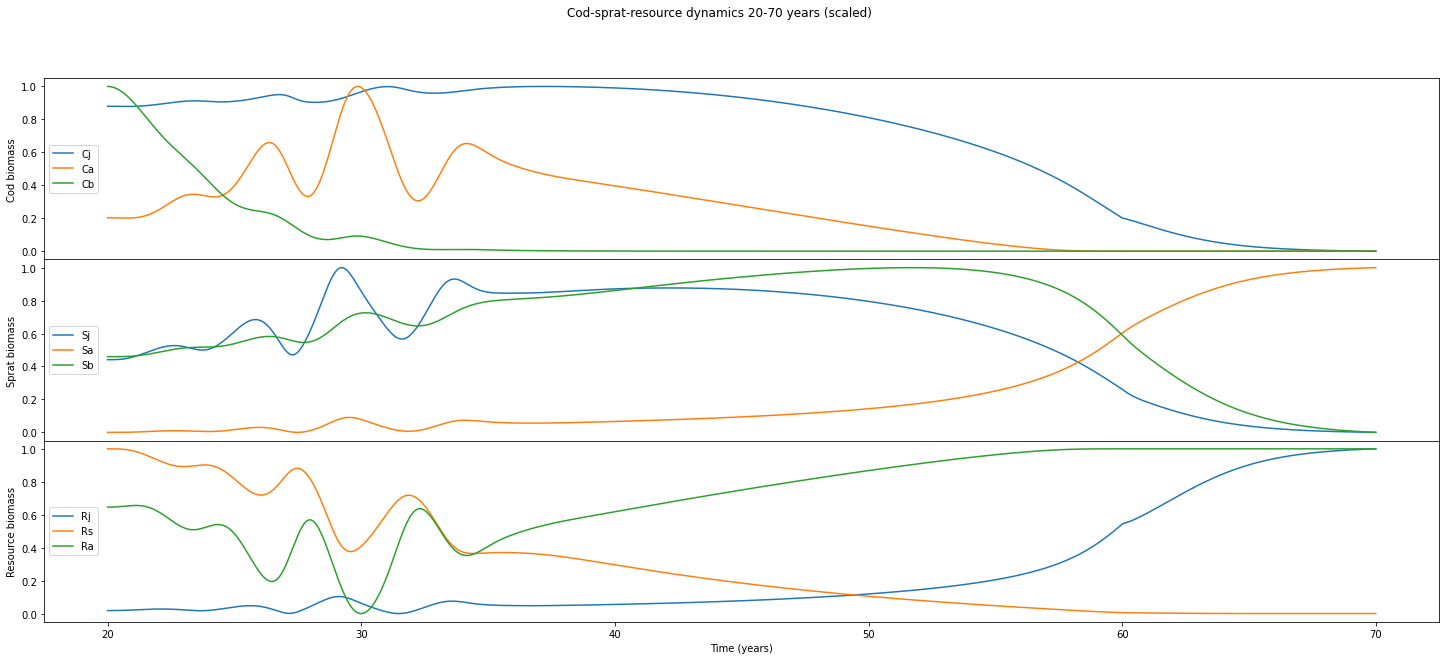

In [14]:
# Select data between 20 and 70 years
ebt_20_70 = select_data(ebt, 20, 70)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'EBT_20_70_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
ebt_20_70.to_csv(EBTScaled_path, index = False)

#### TCDF 20-70 years: first run (in triplicate)

Arguments: Namespace(cuda=False, data=None, dilation_coefficient=3, early_stopping=True, epochs=1000, ground_truth={'data/EBT_20_70_dataset_3650.csv': 'data/EBT_demo_groundtruth.csv'}, hidden_layers=3, kernel_size=3, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=5467, significance=0.9)

 Dataset:  EBT_20_70_dataset_3650.csv

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.097848
Epoch   134: reducing learning rate of group 0 to 1.0000e-02.
Epoch: 250 [25%] 	Loss: 0.000871
Epoch: 500 [50%] 	Loss: 0.000643
Epoch: 750 [75%] 	Loss: 0.000425
Epoch: 1000 [100%] 	Loss: 0.000259
Potential causes:  [2, 0, 3]
Validated causes:  [0]

 Analysis started for target:  Rj
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.103320
Epoch    18: reducing learning rate of group 0 to 1.0000e-02.
Epoch    29: reducing learning rat

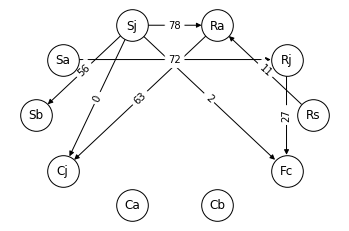

<Figure size 432x288 with 0 Axes>

In [15]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 5467 --plot


Arguments: Namespace(cuda=False, data=['data/EBT_20_70_dataset_3650.csv'], dilation_coefficient=3, early_stopping=True, epochs=1000, hidden_layers=3, kernel_size=3, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=5467, train_test_split=0.5)

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.135441
Epoch    39: reducing learning rate of group 0 to 1.0000e-02.
Epoch: 250 [25%] 	Loss: 0.001729
Epoch: 500 [50%] 	Loss: 0.000276
Epoch: 750 [75%] 	Loss: 0.000176
Epoch: 1000 [100%] 	Loss: 0.000137

 Analysis started for target:  Rj
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.058929
Epoch    46: reducing learning rate of group 0 to 1.0000e-02.
Epoch    67: reducing learning rate of group 0 to 1.0000e-03.
Epoch: 250 [25%] 	Loss: 0.000494
Epoch: 500 [50%] 	Loss: 0.000491
INFO: Early stopping

 Analysis started for t

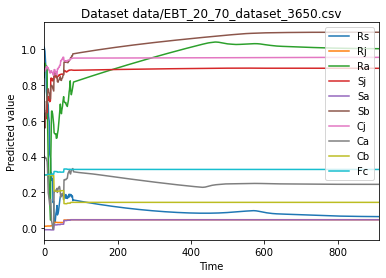

<Figure size 432x288 with 0 Axes>

In [16]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 5467 --plot --train_test_split 0.5

Arguments: Namespace(cuda=False, data=None, dilation_coefficient=3, early_stopping=True, epochs=1000, ground_truth={'data/EBT_20_70_dataset_3650.csv': 'data/EBT_demo_groundtruth.csv'}, hidden_layers=3, kernel_size=3, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=2371, significance=0.9)

 Dataset:  EBT_20_70_dataset_3650.csv

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.110083
Epoch    13: reducing learning rate of group 0 to 1.0000e-02.
Epoch    24: reducing learning rate of group 0 to 1.0000e-03.
Epoch: 250 [25%] 	Loss: 0.079533
Epoch: 500 [50%] 	Loss: 0.012141
Epoch: 750 [75%] 	Loss: 0.004663
Epoch: 1000 [100%] 	Loss: 0.002423
Potential causes:  [8]
Validated causes:  [8]

 Analysis started for target:  Rj
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.106408
Epoch    55: reducing learning rate of g

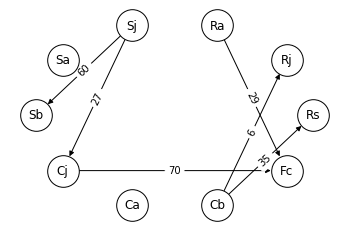

<Figure size 432x288 with 0 Axes>

In [17]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 2371 --plot


Arguments: Namespace(cuda=False, data=['data/EBT_20_70_dataset_3650.csv'], dilation_coefficient=3, early_stopping=True, epochs=1000, hidden_layers=3, kernel_size=3, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=2371, train_test_split=0.5)

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.198539
Epoch    57: reducing learning rate of group 0 to 1.0000e-02.
Epoch    68: reducing learning rate of group 0 to 1.0000e-03.
Epoch    79: reducing learning rate of group 0 to 1.0000e-04.
Epoch    90: reducing learning rate of group 0 to 1.0000e-05.
Epoch   101: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 250 [25%] 	Loss: 0.069517
Epoch: 500 [50%] 	Loss: 0.069489
INFO: Early stopping

 Analysis started for target:  Rj
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.019849
Epoch    25: reducing learning rat

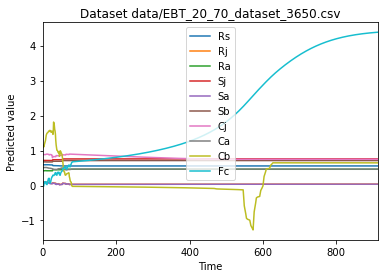

<Figure size 432x288 with 0 Axes>

In [18]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 2371 --plot --train_test_split 0.5

Arguments: Namespace(cuda=False, data=None, dilation_coefficient=3, early_stopping=True, epochs=1000, ground_truth={'data/EBT_20_70_dataset_3650.csv': 'data/EBT_demo_groundtruth.csv'}, hidden_layers=3, kernel_size=3, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=1084, significance=0.9)

 Dataset:  EBT_20_70_dataset_3650.csv

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.387770
Epoch   112: reducing learning rate of group 0 to 1.0000e-02.
Epoch: 250 [25%] 	Loss: 0.002871
Epoch: 500 [50%] 	Loss: 0.001933
Epoch: 750 [75%] 	Loss: 0.001720
Epoch: 1000 [100%] 	Loss: 0.001576
Potential causes:  [4, 9]
Validated causes:  [4, 9]

 Analysis started for target:  Rj
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.344887
Epoch    16: reducing learning rate of group 0 to 1.0000e-02.
Epoch    27: reducing learning rat

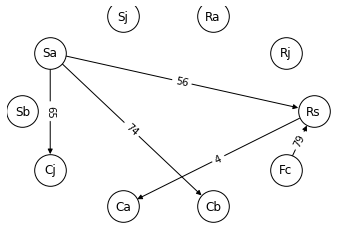

<Figure size 432x288 with 0 Axes>

In [19]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1084 --plot


Arguments: Namespace(cuda=False, data=['data/EBT_20_70_dataset_3650.csv'], dilation_coefficient=3, early_stopping=True, epochs=1000, hidden_layers=3, kernel_size=3, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=1048, train_test_split=0.5)

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.250866
Epoch    41: reducing learning rate of group 0 to 1.0000e-02.
Epoch    78: reducing learning rate of group 0 to 1.0000e-03.
Epoch: 250 [25%] 	Loss: 0.017182
Epoch: 500 [50%] 	Loss: 0.016976
Epoch: 750 [75%] 	Loss: 0.016802
Epoch: 1000 [100%] 	Loss: 0.016631

 Analysis started for target:  Rj
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.005800
Epoch    19: reducing learning rate of group 0 to 1.0000e-02.
Epoch    30: reducing learning rate of group 0 to 1.0000e-03.
Epoch    41: reducing learning rate of group 0 to

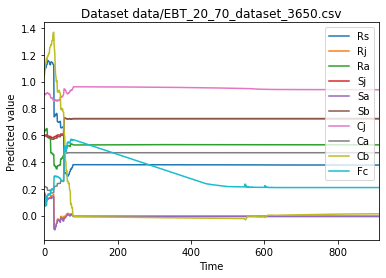

<Figure size 432x288 with 0 Axes>

In [20]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1048 --plot --train_test_split 0.5

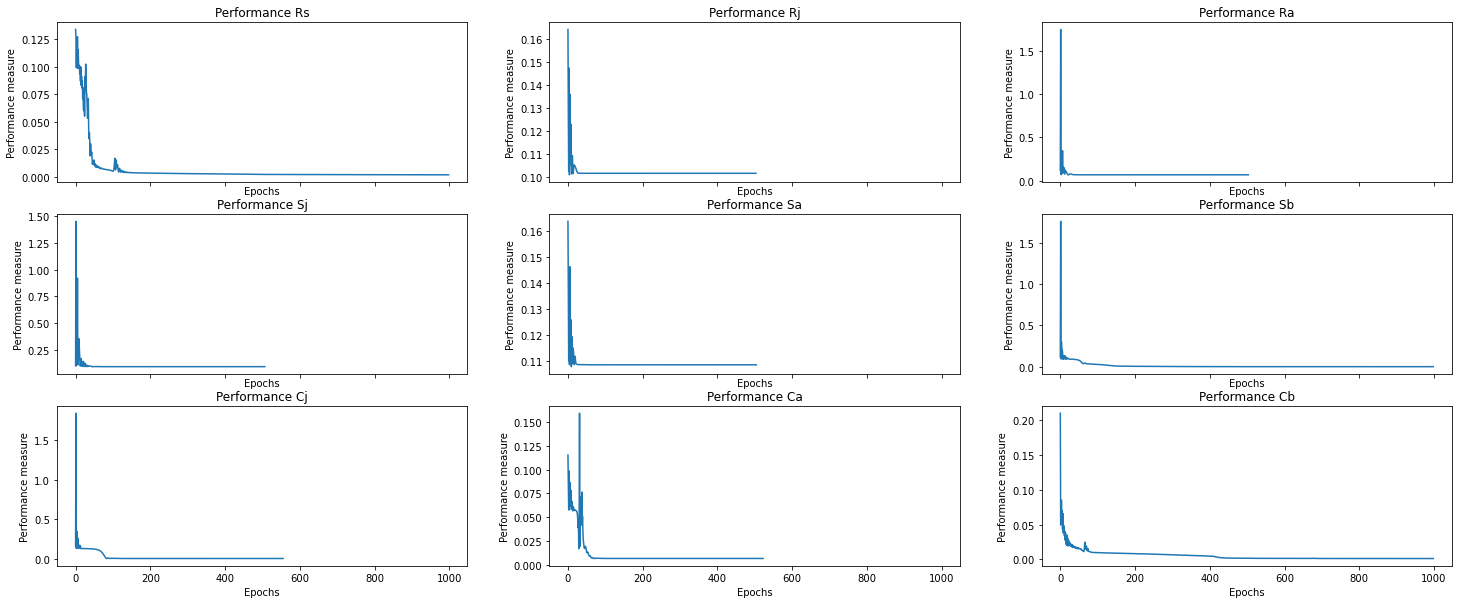

In [21]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

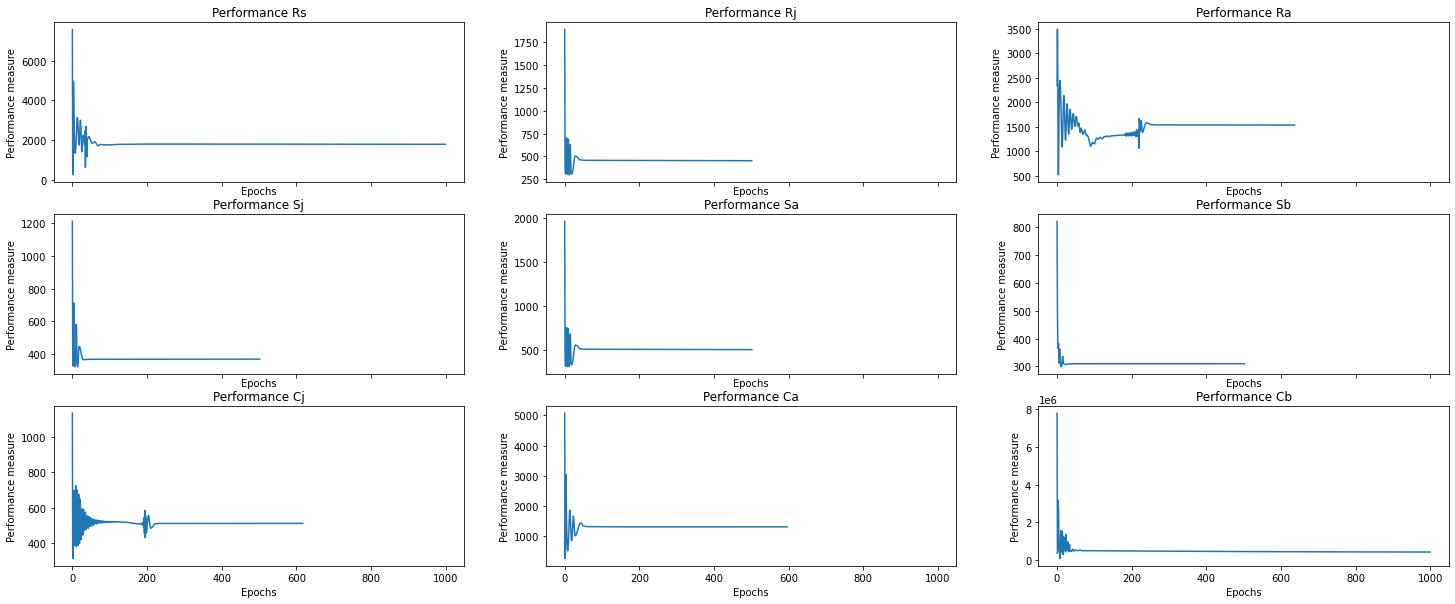

In [22]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 20-70 years: second run (decreased hidden layers by 1, incremented dilation coefficient and kernel size by 1)

Arguments: Namespace(cuda=False, data=None, dilation_coefficient=4, early_stopping=True, epochs=2000, ground_truth={'data/EBT_20_70_dataset_3650.csv': 'data/EBT_demo_groundtruth.csv'}, hidden_layers=2, kernel_size=4, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=5467, significance=0.9)

 Dataset:  EBT_20_70_dataset_3650.csv

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.107474
Epoch    41: reducing learning rate of group 0 to 1.0000e-02.
Epoch    52: reducing learning rate of group 0 to 1.0000e-03.
Epoch    63: reducing learning rate of group 0 to 1.0000e-04.
Epoch    74: reducing learning rate of group 0 to 1.0000e-05.
Epoch    85: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 250 [12%] 	Loss: 0.020158
Epoch: 500 [25%] 	Loss: 0.020097
INFO: Early stopping
Potential causes:  [4, 9, 2]
Validated causes:  [4, 9]

 Analysis started for target:  Rj


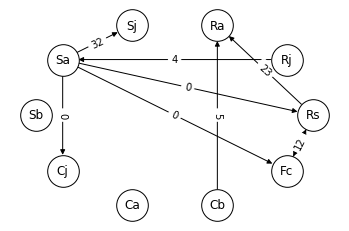

<Figure size 432x288 with 0 Axes>

In [23]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 5467 --plot


Arguments: Namespace(cuda=False, data=['data/EBT_20_70_dataset_3650.csv'], dilation_coefficient=4, early_stopping=True, epochs=2000, hidden_layers=2, kernel_size=4, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=5467, train_test_split=0.5)

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.189217
Epoch   149: reducing learning rate of group 0 to 1.0000e-02.
Epoch   160: reducing learning rate of group 0 to 1.0000e-03.
Epoch   171: reducing learning rate of group 0 to 1.0000e-04.
Epoch   182: reducing learning rate of group 0 to 1.0000e-05.
Epoch   193: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 250 [12%] 	Loss: 0.000810
Epoch: 500 [25%] 	Loss: 0.000806
INFO: Early stopping

 Analysis started for target:  Rj
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.023857
Epoch    21: reducing learning rat

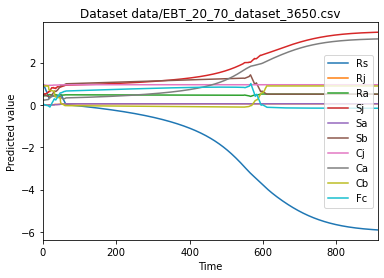

<Figure size 432x288 with 0 Axes>

In [24]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 5467 --plot --train_test_split 0.5

Arguments: Namespace(cuda=False, data=None, dilation_coefficient=4, early_stopping=True, epochs=2000, ground_truth={'data/EBT_20_70_dataset_3650.csv': 'data/EBT_demo_groundtruth.csv'}, hidden_layers=2, kernel_size=4, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=9238, significance=0.9)

 Dataset:  EBT_20_70_dataset_3650.csv

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.119076
Epoch    13: reducing learning rate of group 0 to 1.0000e-02.
Epoch: 250 [12%] 	Loss: 0.002832
Epoch   467: reducing learning rate of group 0 to 1.0000e-03.
Epoch: 500 [25%] 	Loss: 0.001072
Epoch: 750 [38%] 	Loss: 0.001037
Epoch: 1000 [50%] 	Loss: 0.001001
Epoch: 1250 [62%] 	Loss: 0.000966
Epoch: 1500 [75%] 	Loss: 0.000930
Epoch: 1750 [88%] 	Loss: 0.000892
Epoch: 2000 [100%] 	Loss: 0.000851
Potential causes:  [6, 7, 8, 3, 2]
Validated causes:  [6, 7, 3]

 Analysis started for target

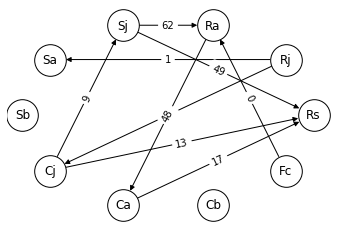

<Figure size 432x288 with 0 Axes>

In [25]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 9238 --plot


Arguments: Namespace(cuda=False, data=['data/EBT_20_70_dataset_3650.csv'], dilation_coefficient=4, early_stopping=True, epochs=2000, hidden_layers=2, kernel_size=4, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=9238, train_test_split=0.5)

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.224863
Epoch    55: reducing learning rate of group 0 to 1.0000e-02.
Epoch: 250 [12%] 	Loss: 0.000414
Epoch: 500 [25%] 	Loss: 0.000156
Epoch   657: reducing learning rate of group 0 to 1.0000e-03.
Epoch: 750 [38%] 	Loss: 0.000107
Epoch: 1000 [50%] 	Loss: 0.000100
INFO: Early stopping

 Analysis started for target:  Rj
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.011328
Epoch    23: reducing learning rate of group 0 to 1.0000e-02.
Epoch    34: reducing learning rate of group 0 to 1.0000e-03.
Epoch    45: reducing learnin

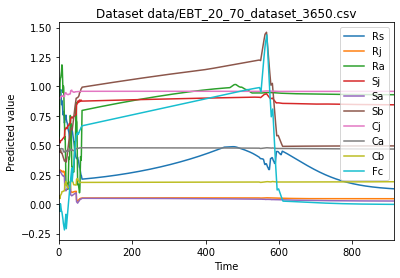

<Figure size 432x288 with 0 Axes>

In [26]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 9238 --plot --train_test_split 0.5

Arguments: Namespace(cuda=False, data=None, dilation_coefficient=4, early_stopping=True, epochs=2000, ground_truth={'data/EBT_20_70_dataset_3650.csv': 'data/EBT_demo_groundtruth.csv'}, hidden_layers=2, kernel_size=4, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=157, significance=0.9)

 Dataset:  EBT_20_70_dataset_3650.csv

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.431800
Epoch    42: reducing learning rate of group 0 to 1.0000e-02.
Epoch: 250 [12%] 	Loss: 0.002349
Epoch: 500 [25%] 	Loss: 0.001382
Epoch   697: reducing learning rate of group 0 to 1.0000e-03.
Epoch: 750 [38%] 	Loss: 0.000930
Epoch: 1000 [50%] 	Loss: 0.000875
Epoch: 1250 [62%] 	Loss: 0.000810
Epoch: 1500 [75%] 	Loss: 0.000736
Epoch: 1750 [88%] 	Loss: 0.000650
Epoch: 2000 [100%] 	Loss: 0.000551
Potential causes:  [2, 8]
Validated causes:  []

 Analysis started for target:  Rj
INFO: Initi

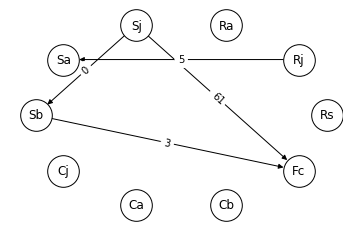

<Figure size 432x288 with 0 Axes>

In [27]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 157 --plot


Arguments: Namespace(cuda=False, data=['data/EBT_20_70_dataset_3650.csv'], dilation_coefficient=4, early_stopping=True, epochs=2000, hidden_layers=2, kernel_size=4, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=157, train_test_split=0.5)

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.751541
Epoch    18: reducing learning rate of group 0 to 1.0000e-02.
Epoch: 250 [12%] 	Loss: 0.000710
Epoch: 500 [25%] 	Loss: 0.000359
Epoch: 750 [38%] 	Loss: 0.000285
Epoch: 1000 [50%] 	Loss: 0.000253
Epoch  1200: reducing learning rate of group 0 to 1.0000e-03.
Epoch  1211: reducing learning rate of group 0 to 1.0000e-04.
Epoch  1231: reducing learning rate of group 0 to 1.0000e-05.
Epoch  1242: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 1250 [62%] 	Loss: 0.000236
Epoch: 1500 [75%] 	Loss: 0.000236
INFO: Early stopping

 Analysis started for target:  Rj
INFO: In

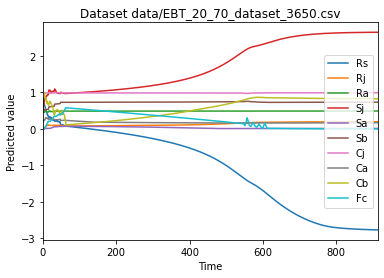

<Figure size 432x288 with 0 Axes>

In [28]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 157 --plot --train_test_split 0.5

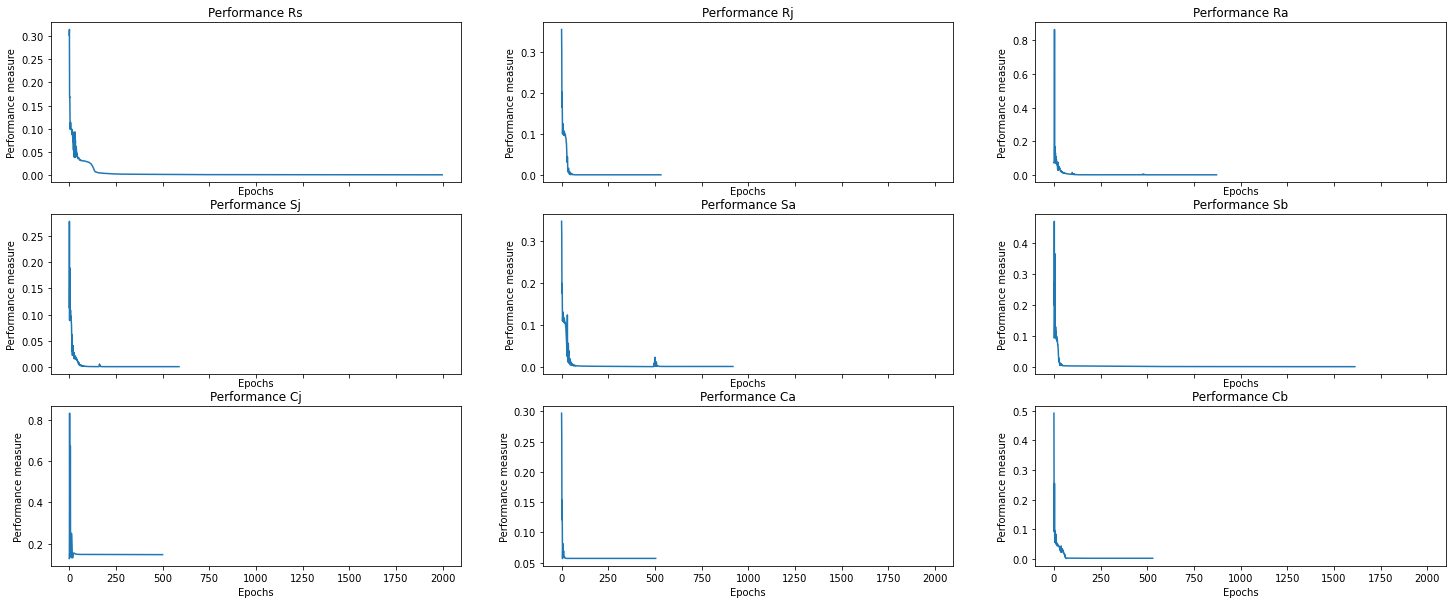

In [29]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

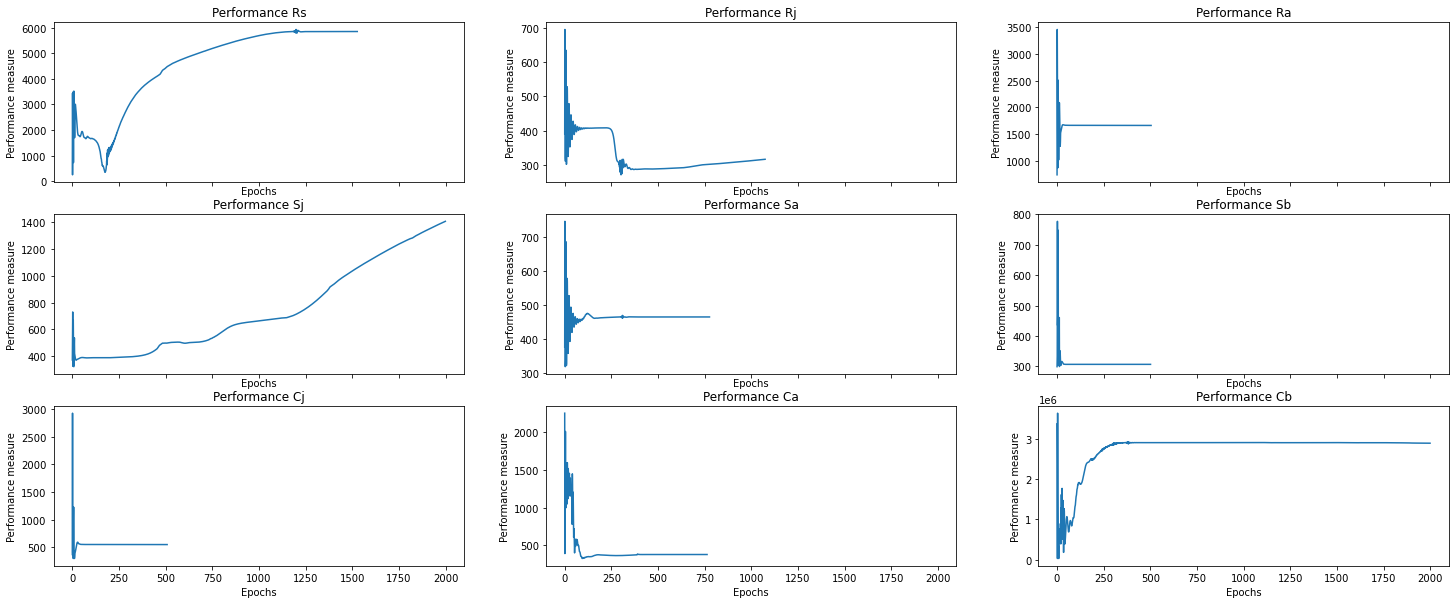

In [30]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 0 - 100 years

Rs        Rj        Ra            Sj        Sa            Sb  \
0     0.999640  0.017874  0.646308  4.437428e-01  0.000014  4.672259e-01   
1     0.999646  0.017873  0.646304  4.437352e-01  0.000014  4.672241e-01   
2     0.999652  0.017871  0.646297  4.437276e-01  0.000013  4.672222e-01   
3     0.999657  0.017870  0.646290  4.437199e-01  0.000013  4.672202e-01   
4     0.999663  0.017869  0.646283  4.437122e-01  0.000012  4.672181e-01   
...        ...       ...       ...           ...       ...           ...   
3636  0.000066  1.000000  1.000000  4.585154e-09  1.000000  9.423261e-09   
3637  0.000066  1.000000  1.000000  4.248188e-09  1.000000  8.722811e-09   
3638  0.000066  1.000000  1.000000  3.911221e-09  1.000000  8.026379e-09   
3639  0.000066  1.000000  1.000000  3.574254e-09  1.000000  7.333965e-09   
3640  0.000066  1.000000  1.000000  3.237288e-09  1.000000  6.645569e-09   

                Cj            Ca            Cb   Fc  
0     8.801519e-01  2.027306e-01  9.985097e-01  0.0  
1     8.801510e-01  2.027348e-01  9.985240e-01  0.0  
2     8.801499e-01  2.027386e-01  9.985382e-01  0.0  
3     8.801486e-01  2.027421e-01  9.985525e-01  0.0  
4     8.801471e-01  2.027453e-01  9.985667e-01  0.0  
...            ...           ...           ...  ...  
3636  3.874721e-09  8.574995e-10  1.677539e-07  0.0  
3637  3.587461e-09  7.941070e-10  1.668643e-07  0.0  
3638  3.301846e-09  7.310527e-10  1.659796e-07  0.0  
3639  3.017886e-09  6.683342e-10  1.650995e-07  0.0  
3640  2.735561e-09  6.059463e-10  1.642241e-07  0.0  

[3641 rows x 10 columns]

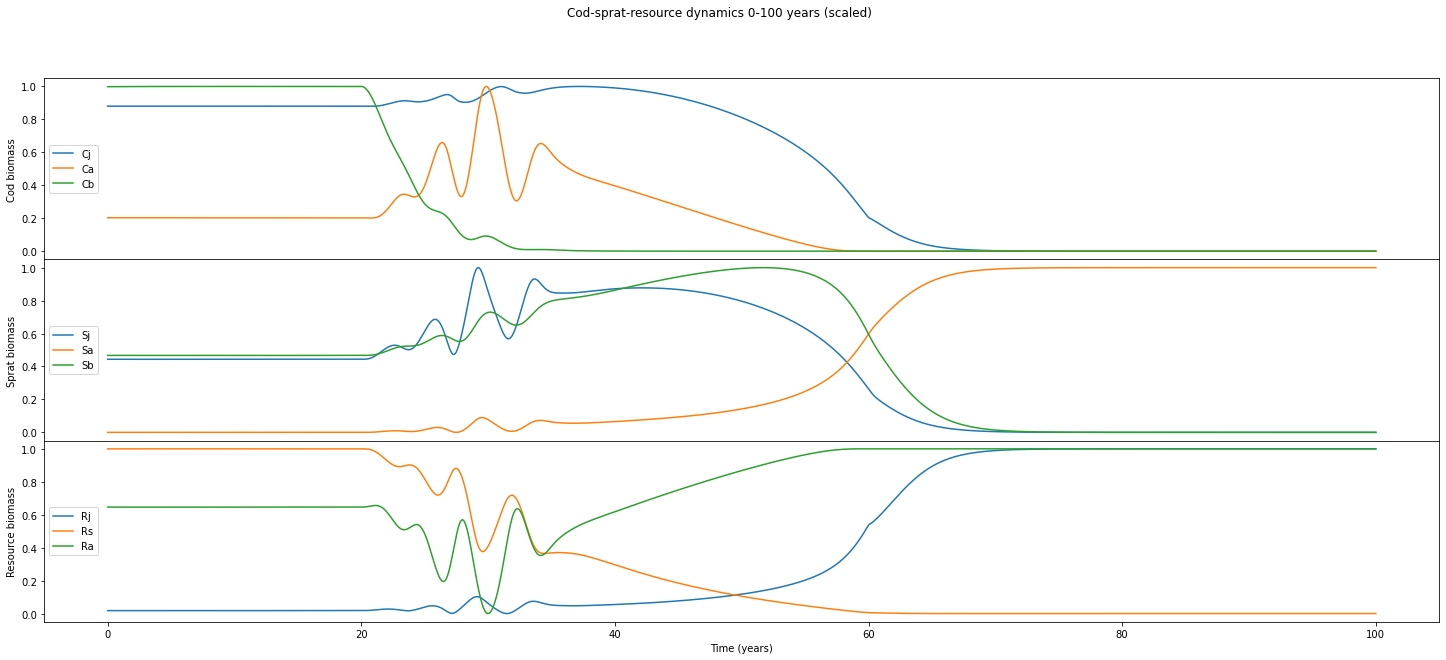

In [31]:
# Select data between 0 and 100 years
ebt_0_100 = select_data(ebt, 0, 100)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'EBT_0_100_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
ebt_0_100.to_csv(EBTScaled_path, index = False)

#### TCDF 0-100 years: first run (in triplicate)

Arguments: Namespace(cuda=False, data=None, dilation_coefficient=4, early_stopping=True, epochs=2000, ground_truth={'data/EBT_0_100_dataset_3650.csv': 'data/EBT_demo_groundtruth.csv'}, hidden_layers=2, kernel_size=4, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=37519, significance=0.9)

 Dataset:  EBT_0_100_dataset_3650.csv

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.491522
Epoch    31: reducing learning rate of group 0 to 1.0000e-02.
Epoch    42: reducing learning rate of group 0 to 1.0000e-03.
Epoch    53: reducing learning rate of group 0 to 1.0000e-04.
Epoch    64: reducing learning rate of group 0 to 1.0000e-05.
Epoch    75: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 250 [12%] 	Loss: 0.042432
Epoch: 500 [25%] 	Loss: 0.042137
INFO: Early stopping
Potential causes:  [8, 1, 0]
Validated causes:  [8]

 Analysis started for target:  Rj
IN

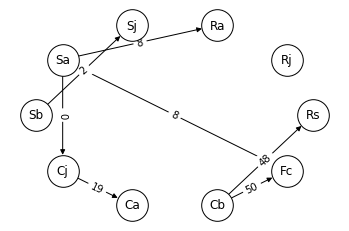

<Figure size 432x288 with 0 Axes>

In [32]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot

Arguments: Namespace(cuda=False, data=['data/EBT_0_100_dataset_3650.csv'], dilation_coefficient=4, early_stopping=True, epochs=2000, hidden_layers=2, kernel_size=4, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=37519, train_test_split=0.4)

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 1.121335
Epoch    35: reducing learning rate of group 0 to 1.0000e-02.
Epoch    81: reducing learning rate of group 0 to 1.0000e-03.
Epoch    92: reducing learning rate of group 0 to 1.0000e-04.
Epoch   103: reducing learning rate of group 0 to 1.0000e-05.
Epoch   114: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 250 [12%] 	Loss: 0.004907
Epoch: 500 [25%] 	Loss: 0.004899
INFO: Early stopping

 Analysis started for target:  Rj
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.061320
Epoch    23: reducing learning ra

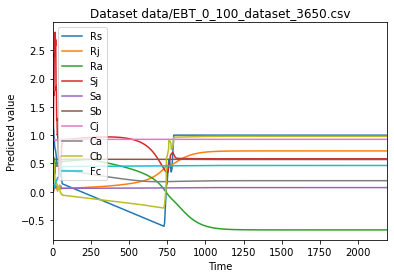

<Figure size 432x288 with 0 Axes>

In [33]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot --train_test_split 0.4

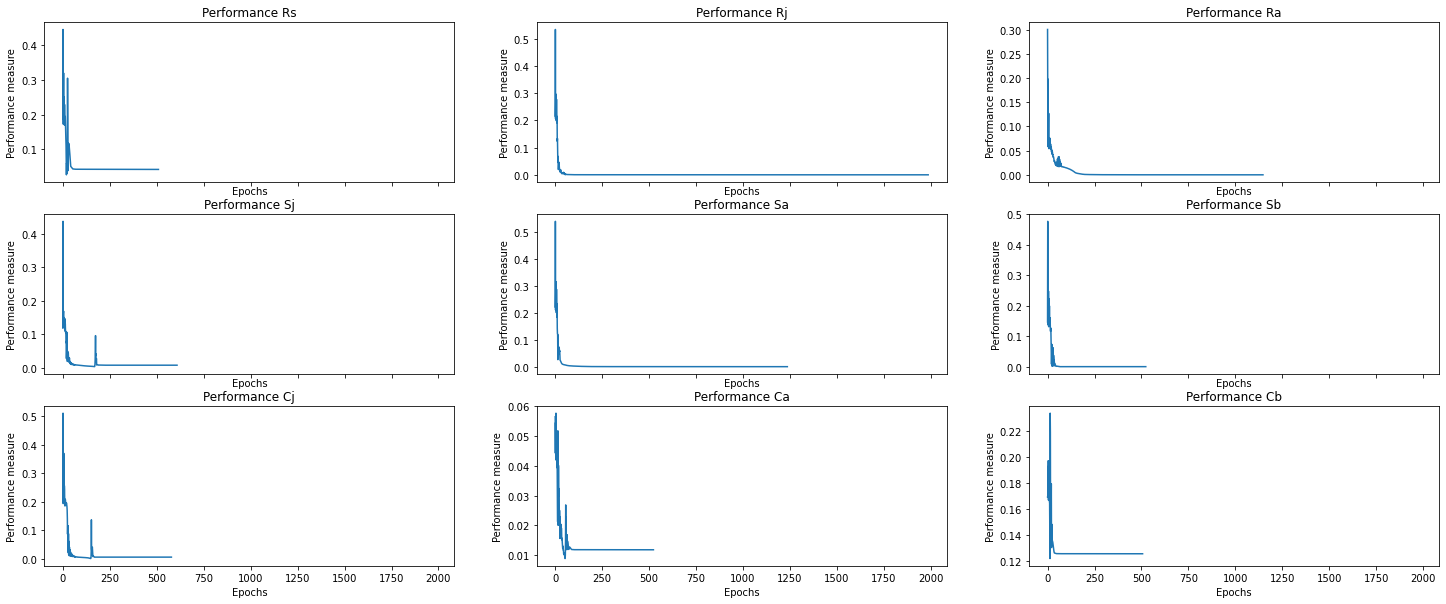

In [34]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

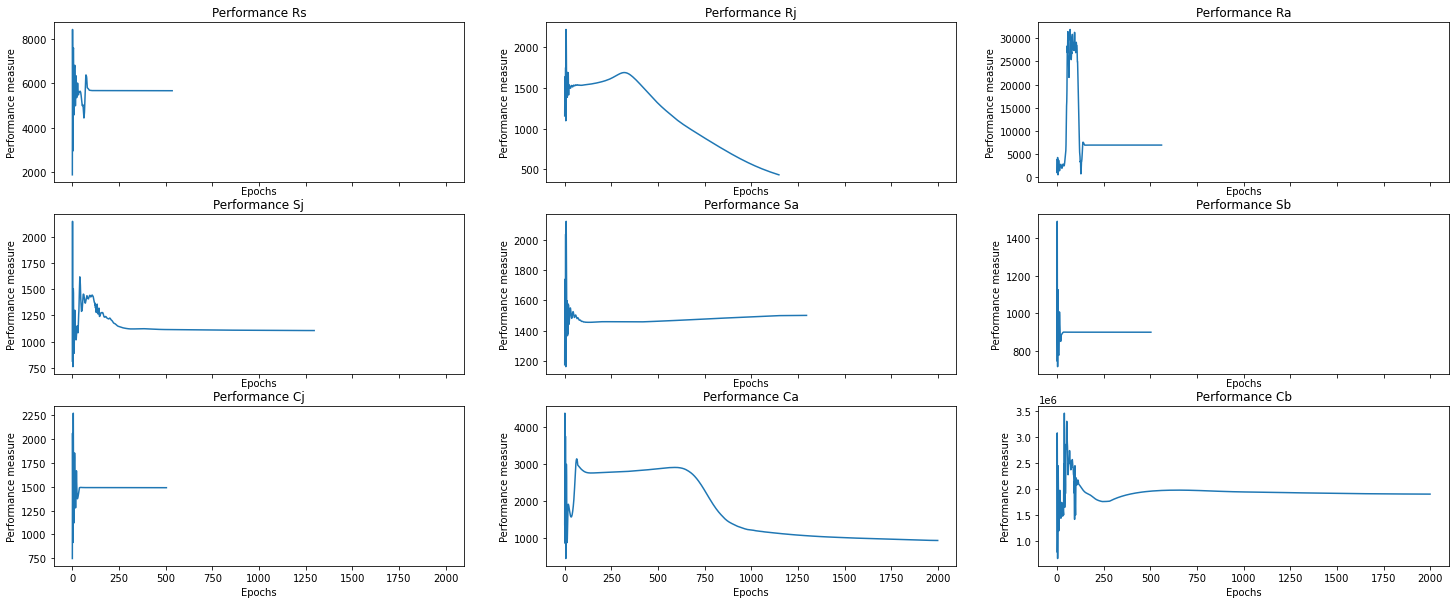

In [35]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

Arguments: Namespace(cuda=False, data=None, dilation_coefficient=4, early_stopping=True, epochs=2000, ground_truth={'data/EBT_0_100_dataset_3650.csv': 'data/EBT_demo_groundtruth.csv'}, hidden_layers=2, kernel_size=4, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=15787, significance=0.9)

 Dataset:  EBT_0_100_dataset_3650.csv

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.446068
Epoch   146: reducing learning rate of group 0 to 1.0000e-02.
Epoch   157: reducing learning rate of group 0 to 1.0000e-03.
Epoch   168: reducing learning rate of group 0 to 1.0000e-04.
Epoch   179: reducing learning rate of group 0 to 1.0000e-05.
Epoch   190: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 250 [12%] 	Loss: 0.002434
Epoch: 500 [25%] 	Loss: 0.002432
INFO: Early stopping
Potential causes:  [0, 5, 4, 9, 8]
Validated causes:  [0]

 Analysis started for target: 

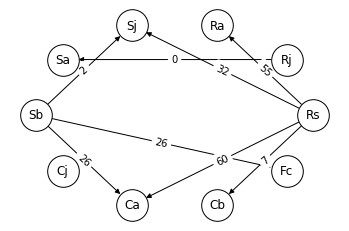

<Figure size 432x288 with 0 Axes>

In [36]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 15787 --plot

Arguments: Namespace(cuda=False, data=['data/EBT_0_100_dataset_3650.csv'], dilation_coefficient=4, early_stopping=True, epochs=2000, hidden_layers=2, kernel_size=4, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=15787, train_test_split=0.4)

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 1.037286
Epoch    16: reducing learning rate of group 0 to 1.0000e-02.
Epoch    38: reducing learning rate of group 0 to 1.0000e-03.
Epoch: 250 [12%] 	Loss: 0.061798
Epoch: 500 [25%] 	Loss: 0.032679
Epoch: 750 [38%] 	Loss: 0.007419
Epoch: 1000 [50%] 	Loss: 0.005681
Epoch: 1250 [62%] 	Loss: 0.003611
Epoch: 1500 [75%] 	Loss: 0.003539
Epoch: 1750 [88%] 	Loss: 0.003498
Epoch: 2000 [100%] 	Loss: 0.003456

 Analysis started for target:  Rj
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.042465
Epoch    51: reducing learning rate 

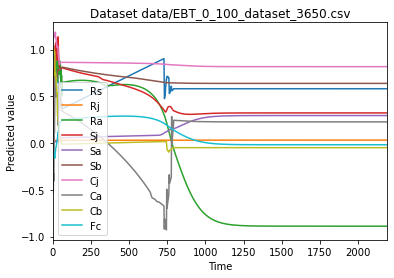

<Figure size 432x288 with 0 Axes>

In [37]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 15787 --plot --train_test_split 0.4

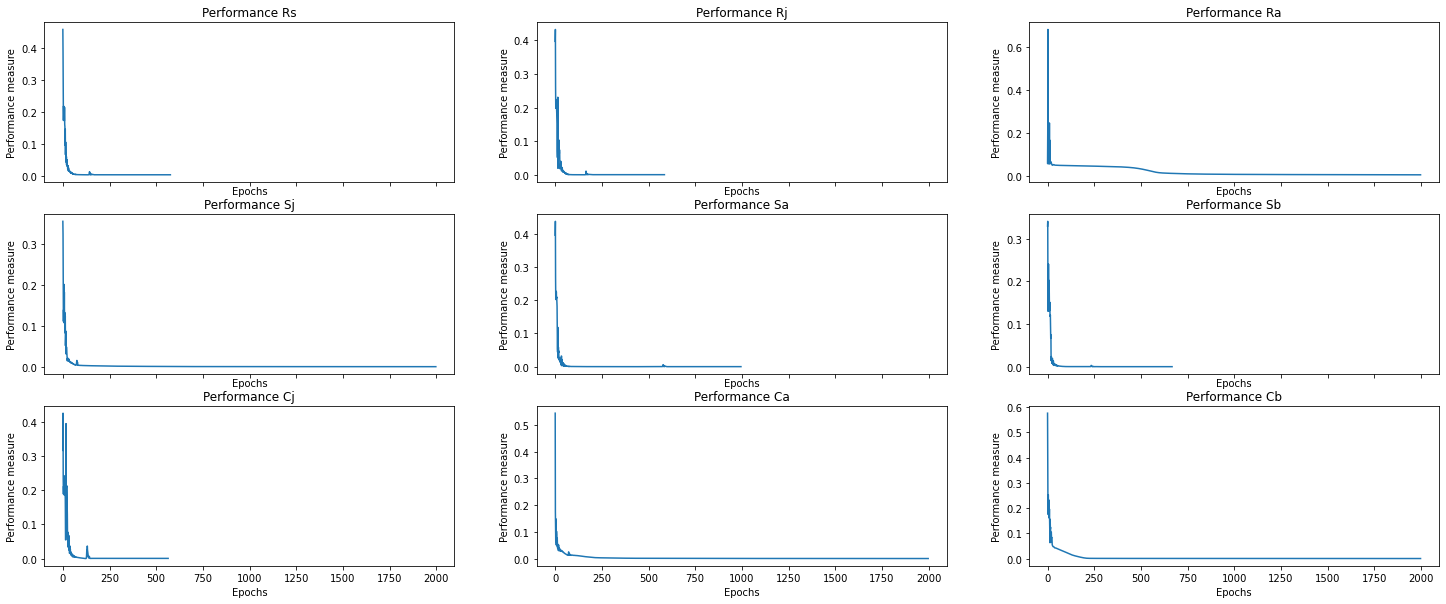

In [38]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

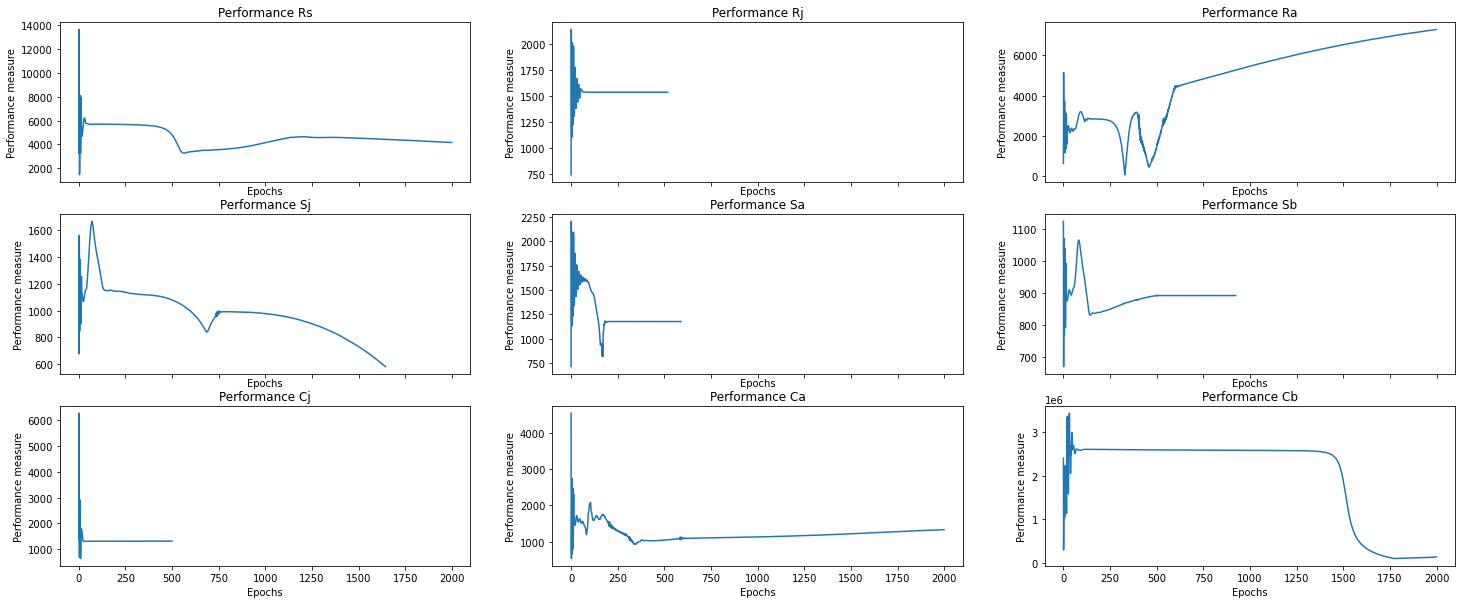

In [39]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

Arguments: Namespace(cuda=False, data=None, dilation_coefficient=4, early_stopping=True, epochs=2000, ground_truth={'data/EBT_0_100_dataset_3650.csv': 'data/EBT_demo_groundtruth.csv'}, hidden_layers=2, kernel_size=4, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=74326, significance=0.9)

 Dataset:  EBT_0_100_dataset_3650.csv

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.201729
Epoch   148: reducing learning rate of group 0 to 1.0000e-02.
Epoch: 250 [12%] 	Loss: 0.000283
Epoch: 500 [25%] 	Loss: 0.000196
Epoch: 750 [38%] 	Loss: 0.000148
Epoch: 1000 [50%] 	Loss: 0.000116
Epoch: 1250 [62%] 	Loss: 0.000090
Epoch: 1500 [75%] 	Loss: 0.000074
INFO: Early stopping
Potential causes:  [4, 0, 7, 6, 8]
Validated causes:  [0]

 Analysis started for target:  Rj
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.261556
E

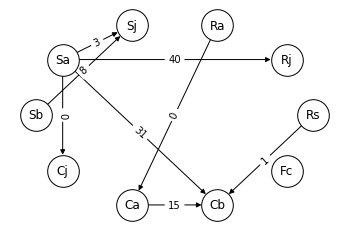

<Figure size 432x288 with 0 Axes>

In [40]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 74326 --plot

Arguments: Namespace(cuda=False, data=['data/EBT_0_100_dataset_3650.csv'], dilation_coefficient=4, early_stopping=True, epochs=2000, hidden_layers=2, kernel_size=4, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=74326, train_test_split=0.4)

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.469149
Epoch    54: reducing learning rate of group 0 to 1.0000e-02.
Epoch    74: reducing learning rate of group 0 to 1.0000e-03.
Epoch: 250 [12%] 	Loss: 0.004467
Epoch: 500 [25%] 	Loss: 0.004352
Epoch: 750 [38%] 	Loss: 0.004242
Epoch: 1000 [50%] 	Loss: 0.003806
Epoch: 1250 [62%] 	Loss: 0.000867
Epoch: 1500 [75%] 	Loss: 0.000768
Epoch: 1750 [88%] 	Loss: 0.000705
Epoch: 2000 [100%] 	Loss: 0.000654

 Analysis started for target:  Rj
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.021444
Epoch    59: reducing learning rate 

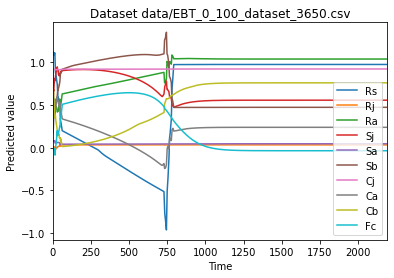

<Figure size 432x288 with 0 Axes>

In [41]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 74326 --plot --train_test_split 0.4

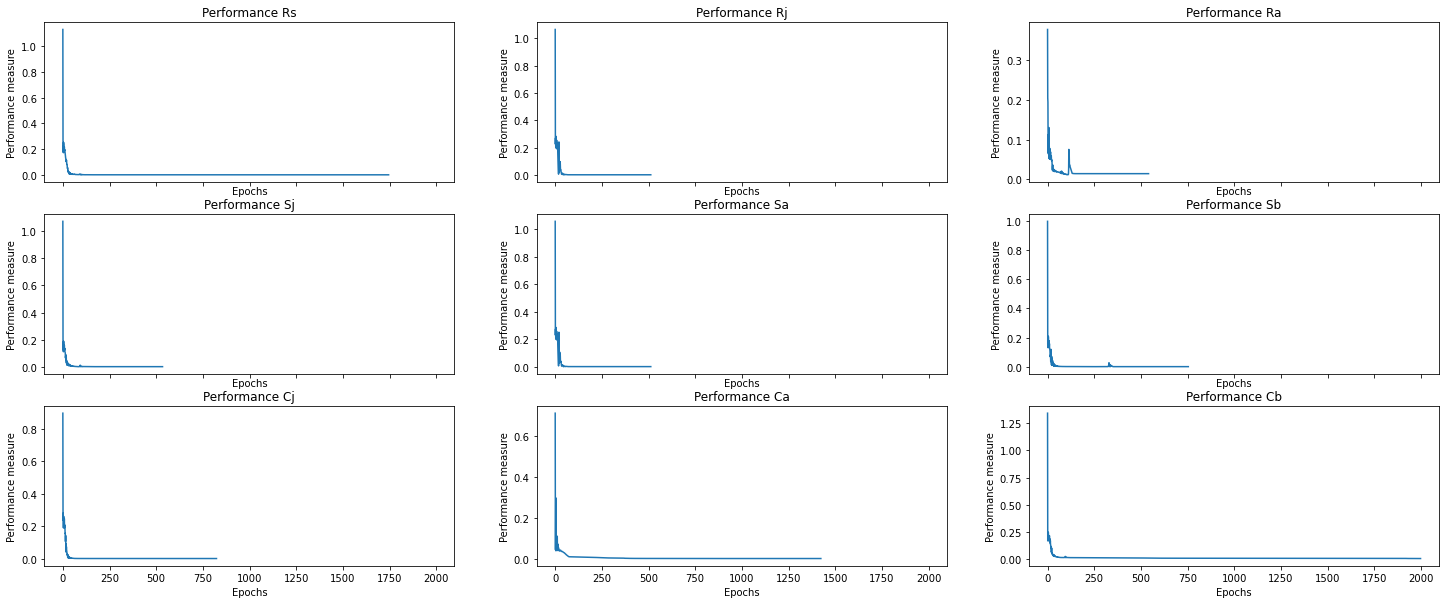

In [42]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

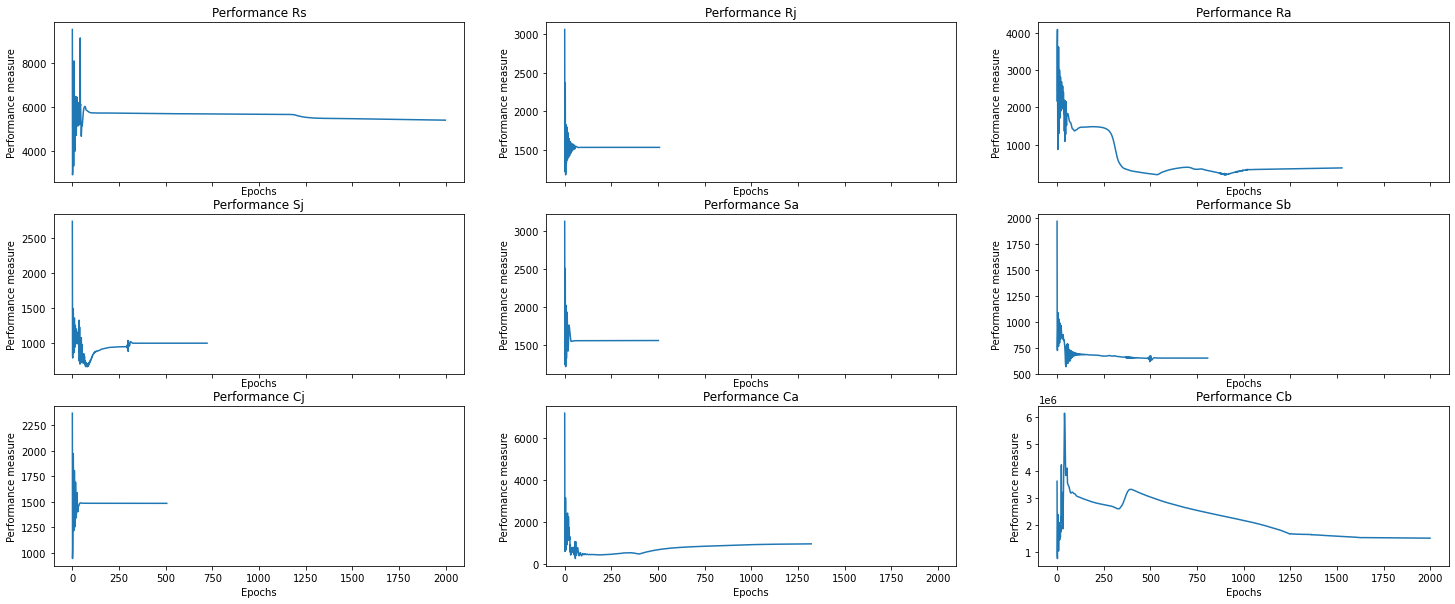

In [43]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

#### TCDF 0-100 years: second run (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

Arguments: Namespace(cuda=False, data=None, dilation_coefficient=3, early_stopping=True, epochs=2000, ground_truth={'data/EBT_0_100_dataset_3650.csv': 'data/EBT_demo_groundtruth.csv'}, hidden_layers=3, kernel_size=3, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=1111, significance=0.9)

 Dataset:  EBT_0_100_dataset_3650.csv

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.418130
Epoch    31: reducing learning rate of group 0 to 1.0000e-02.
Epoch: 250 [12%] 	Loss: 0.003553
Epoch: 500 [25%] 	Loss: 0.002730
Epoch: 750 [38%] 	Loss: 0.002091
Epoch: 1000 [50%] 	Loss: 0.001532
Epoch: 1250 [62%] 	Loss: 0.001093
Epoch: 1500 [75%] 	Loss: 0.000721
Epoch: 1750 [88%] 	Loss: 0.000360
Epoch: 2000 [100%] 	Loss: 0.000211
Potential causes:  [0]
Validated causes:  [0]

 Analysis started for target:  Rj
INFO: Initializing learning rate scheduler
INFO: Initializing early stoppi

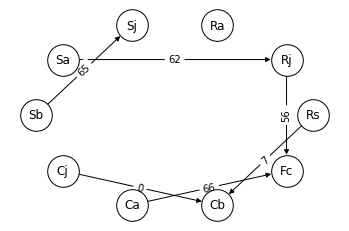

<Figure size 432x288 with 0 Axes>

In [44]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1111 --plot

Arguments: Namespace(cuda=False, data=['data/EBT_0_100_dataset_3650.csv'], dilation_coefficient=3, early_stopping=True, epochs=2000, hidden_layers=3, kernel_size=3, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=1111, train_test_split=0.4)

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.984137
Epoch    22: reducing learning rate of group 0 to 1.0000e-02.
Epoch    69: reducing learning rate of group 0 to 1.0000e-03.
Epoch: 250 [12%] 	Loss: 0.002771
Epoch: 500 [25%] 	Loss: 0.001604
Epoch: 750 [38%] 	Loss: 0.001030
Epoch: 1000 [50%] 	Loss: 0.000869
Epoch: 1250 [62%] 	Loss: 0.000825
Epoch: 1500 [75%] 	Loss: 0.000796
Epoch: 1750 [88%] 	Loss: 0.000773
Epoch: 2000 [100%] 	Loss: 0.000755

 Analysis started for target:  Rj
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.031981
Epoch    27: reducing learning rate o

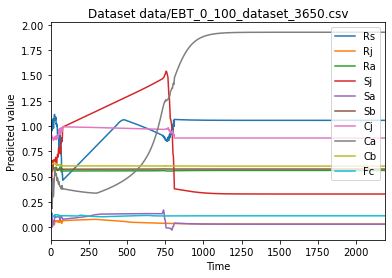

<Figure size 432x288 with 0 Axes>

In [45]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1111 --plot --train_test_split 0.4

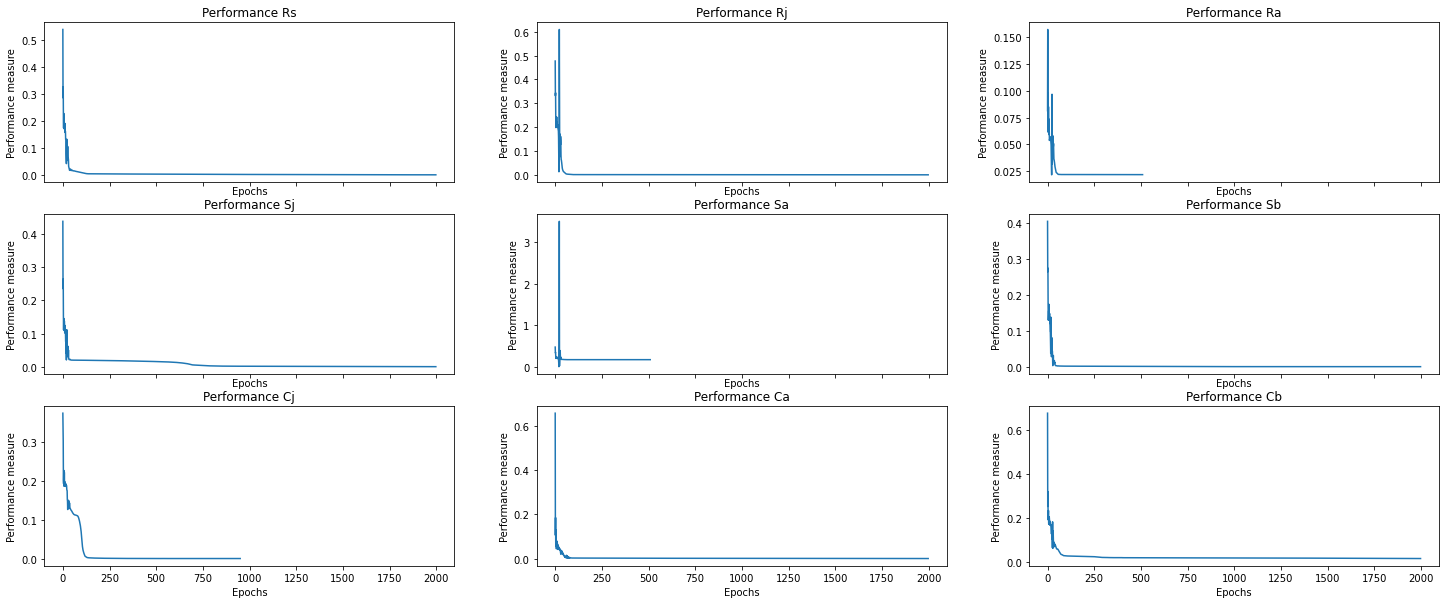

In [46]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

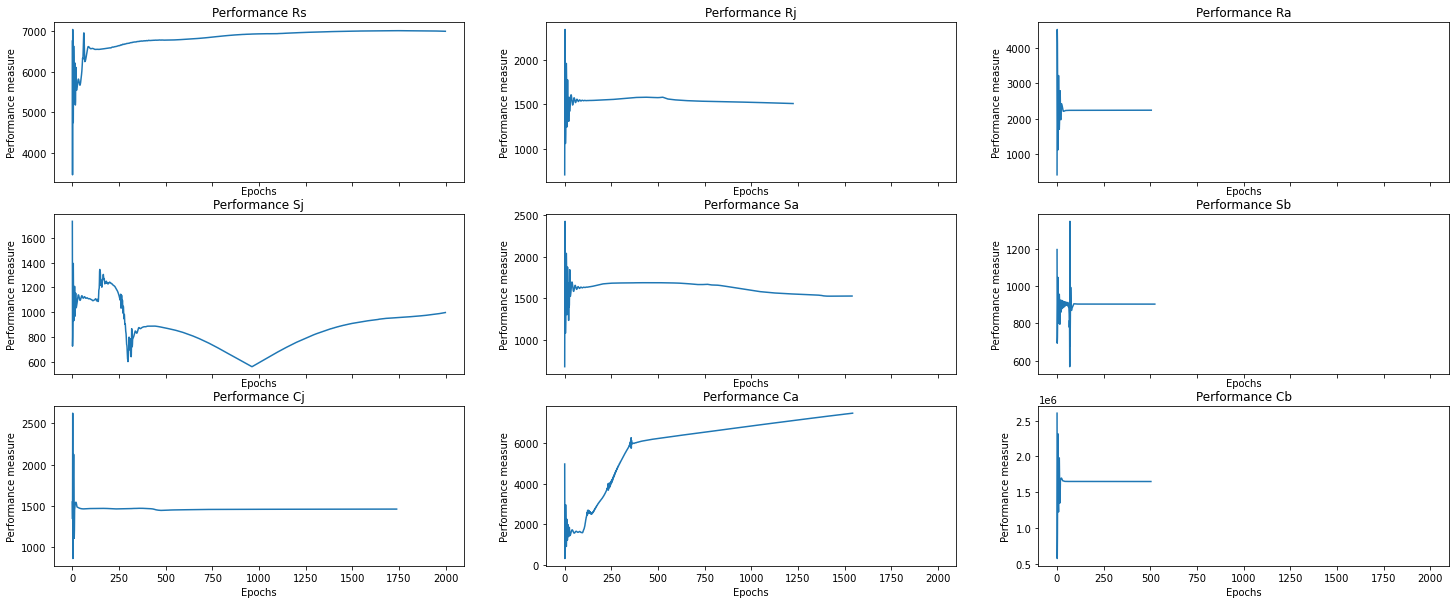

In [47]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

Arguments: Namespace(cuda=False, data=None, dilation_coefficient=3, early_stopping=True, epochs=2000, ground_truth={'data/EBT_0_100_dataset_3650.csv': 'data/EBT_demo_groundtruth.csv'}, hidden_layers=3, kernel_size=3, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=18040, significance=0.9)

 Dataset:  EBT_0_100_dataset_3650.csv

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.188394
Epoch    76: reducing learning rate of group 0 to 1.0000e-02.
Epoch    87: reducing learning rate of group 0 to 1.0000e-03.
Epoch    98: reducing learning rate of group 0 to 1.0000e-04.
Epoch   109: reducing learning rate of group 0 to 1.0000e-05.
Epoch   120: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 250 [12%] 	Loss: 0.103167
Epoch: 500 [25%] 	Loss: 0.103004
INFO: Early stopping
Potential causes:  [6, 7, 9]
Validated causes:  [6]

 Analysis started for target:  Rj
IN

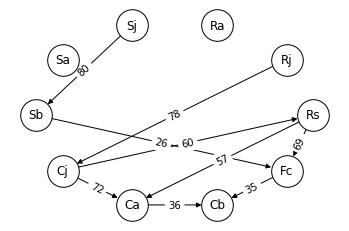

<Figure size 432x288 with 0 Axes>

In [48]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 18040 --plot

Arguments: Namespace(cuda=False, data=['data/EBT_0_100_dataset_3650.csv'], dilation_coefficient=3, early_stopping=True, epochs=2000, hidden_layers=3, kernel_size=3, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=18040, train_test_split=0.4)

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.414987
Epoch    97: reducing learning rate of group 0 to 1.0000e-02.
Epoch   108: reducing learning rate of group 0 to 1.0000e-03.
Epoch   119: reducing learning rate of group 0 to 1.0000e-04.
Epoch   130: reducing learning rate of group 0 to 1.0000e-05.
Epoch   141: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 250 [12%] 	Loss: 0.045356
Epoch: 500 [25%] 	Loss: 0.045146
INFO: Early stopping

 Analysis started for target:  Rj
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.036195
Epoch: 250 [12%] 	Loss: 0.000016


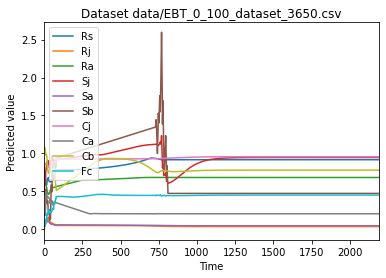

<Figure size 432x288 with 0 Axes>

In [49]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 18040 --plot --train_test_split 0.4

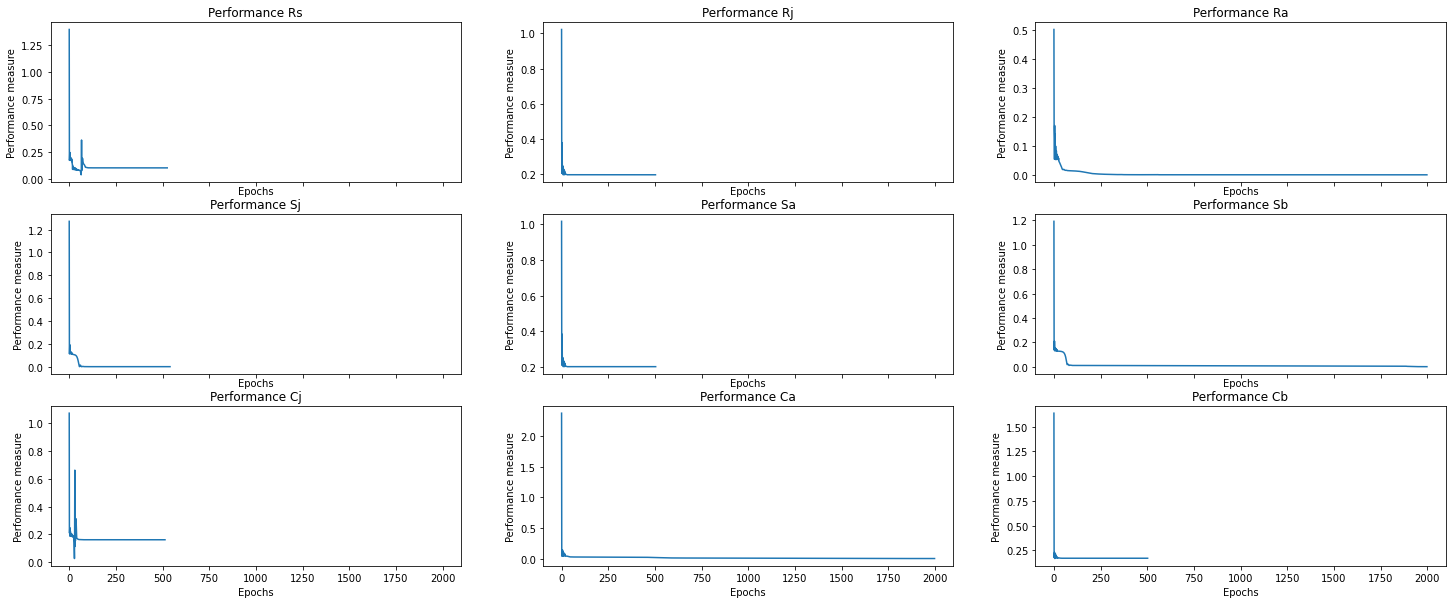

In [50]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

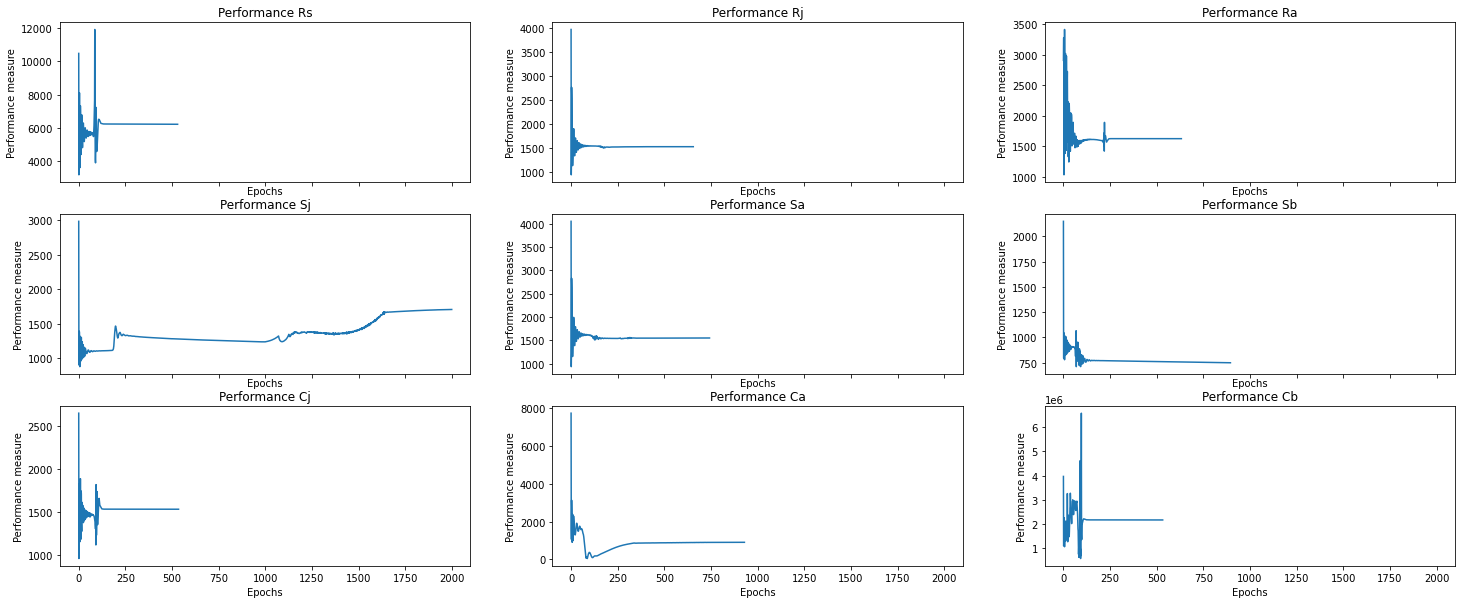

In [51]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

Arguments: Namespace(cuda=False, data=None, dilation_coefficient=3, early_stopping=True, epochs=2000, ground_truth={'data/EBT_0_100_dataset_3650.csv': 'data/EBT_demo_groundtruth.csv'}, hidden_layers=3, kernel_size=3, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=86547, significance=0.9)

 Dataset:  EBT_0_100_dataset_3650.csv

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.486768
Epoch    38: reducing learning rate of group 0 to 1.0000e-02.
Epoch    56: reducing learning rate of group 0 to 1.0000e-03.
Epoch: 250 [12%] 	Loss: 0.019847
Epoch: 500 [25%] 	Loss: 0.011658
Epoch: 750 [38%] 	Loss: 0.003321
Epoch: 1000 [50%] 	Loss: 0.002180
Epoch: 1250 [62%] 	Loss: 0.001713
Epoch: 1500 [75%] 	Loss: 0.001340
Epoch: 1750 [88%] 	Loss: 0.001165
Epoch: 2000 [100%] 	Loss: 0.001019
Potential causes:  [8, 2]
Validated causes:  [8]

 Analysis started for target:  Rj
INFO: In

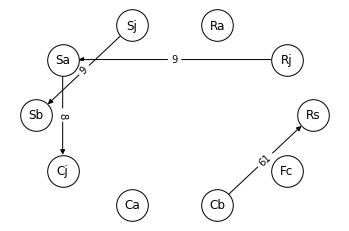

<Figure size 432x288 with 0 Axes>

In [52]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 86547 --plot

Arguments: Namespace(cuda=False, data=['data/EBT_0_100_dataset_3650.csv'], dilation_coefficient=3, early_stopping=True, epochs=2000, hidden_layers=3, kernel_size=3, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=86547, train_test_split=0.4)

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 1.112409
Epoch    22: reducing learning rate of group 0 to 1.0000e-02.
Epoch    33: reducing learning rate of group 0 to 1.0000e-03.
Epoch    44: reducing learning rate of group 0 to 1.0000e-04.
Epoch    55: reducing learning rate of group 0 to 1.0000e-05.
Epoch    66: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 250 [12%] 	Loss: 0.064938
Epoch: 500 [25%] 	Loss: 0.064931
INFO: Early stopping

 Analysis started for target:  Rj
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.059207
Epoch    33: reducing learning ra

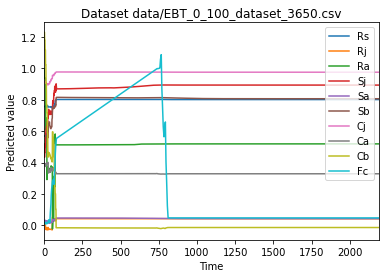

<Figure size 432x288 with 0 Axes>

In [53]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 86547 --plot --train_test_split 0.4

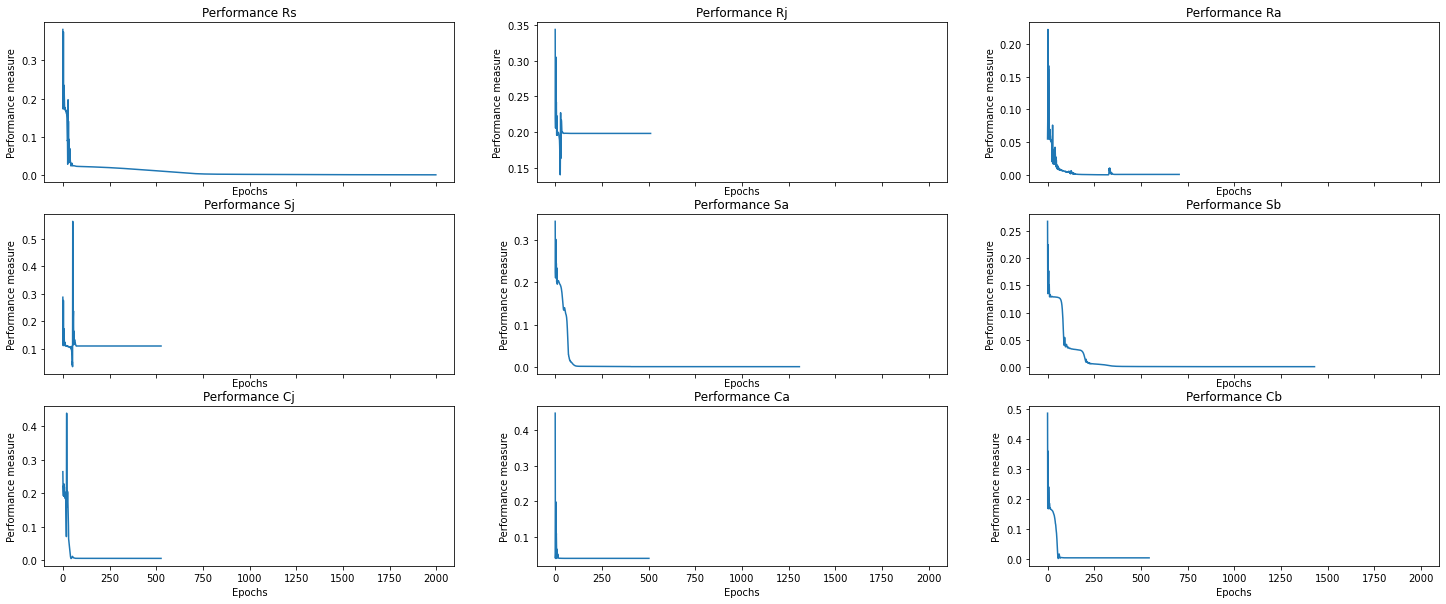

In [54]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

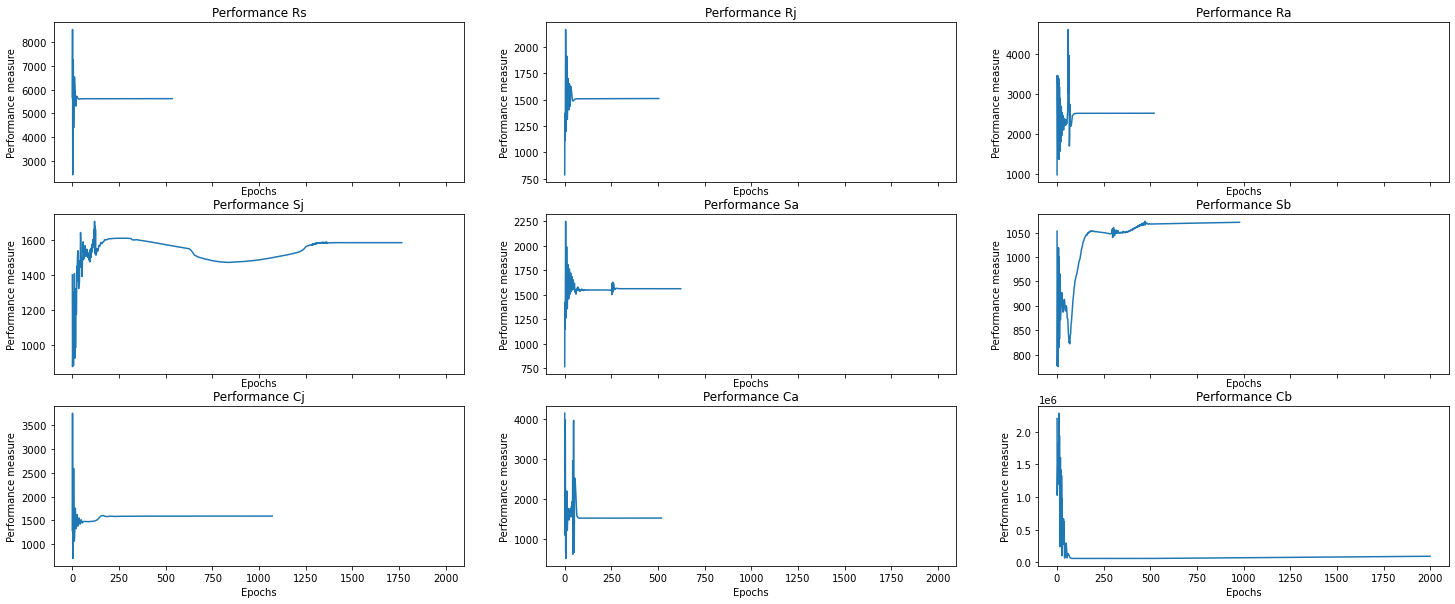

In [55]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

### TCDF with EBT equilibrium dynamics

This data represents the tritrophic biomasses before the introduced fishing pressure on cod. The system first finds it equilibrium and remains stable for ~20 years. Therefore, no relations should be found by the machine learning model.

#### 0 - 20 years

Rs        Rj        Ra        Sj        Sa        Sb        Cj  \
0    0.000000  0.131239  1.000000  1.000000  0.581903  1.000000  1.000000   
1    0.015019  0.114146  0.983898  0.944488  0.567858  0.993550  0.995603   
2    0.030704  0.098504  0.960168  0.888237  0.551544  0.986834  0.990440   
3    0.047023  0.083665  0.934528  0.831583  0.533157  0.979837  0.984502   
4    0.063924  0.069699  0.909079  0.774851  0.512900  0.972551  0.977787   
..        ...       ...       ...       ...       ...       ...       ...   
716  0.975154  0.974466  0.140207  0.108461  0.980770  0.020867  0.023311   
717  0.975156  0.974464  0.140195  0.108451  0.980763  0.020867  0.023311   
718  0.975158  0.974458  0.140195  0.108440  0.980755  0.020867  0.023311   
719  0.975160  0.974455  0.140183  0.108430  0.980748  0.020868  0.023311   
720  0.975163  0.974453  0.140183  0.108420  0.980740  0.020868  0.023310   

           Ca        Cb   Fc  
0    0.000000  0.000000  0.0  
1    0.045801  0.009540  0.0  
2    0.088210  0.019098  0.0  
3    0.127219  0.028662  0.0  
4    0.162835  0.038222  0.0  
..        ...       ...  ...  
716  0.478149  0.986273  0.0  
717  0.478162  0.986272  0.0  
718  0.478174  0.986272  0.0  
719  0.478185  0.986271  0.0  
720  0.478195  0.986270  0.0  

[721 rows x 10 columns]

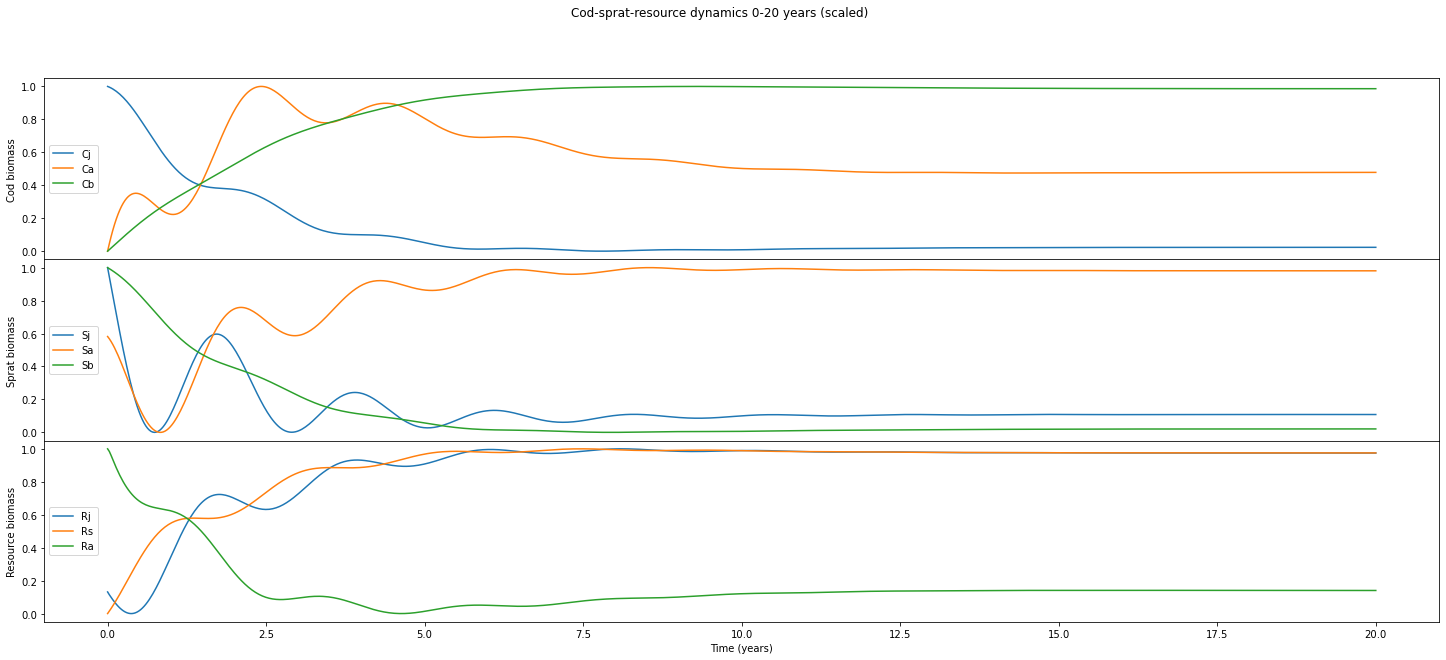

In [56]:
# Select data between 0 and 100 years
ebt_0_20 = select_data(ebt, 0, 20)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'EBT_0_20_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
ebt_0_20.to_csv(EBTScaled_path, index = False)

#### TCDF 0 - 20 years: first run (in triplicate)

Arguments: Namespace(cuda=False, data=None, dilation_coefficient=4, early_stopping=True, epochs=2000, ground_truth={'data/EBT_0_20_dataset_3650.csv': 'data/EBT_demo_groundtruth.csv'}, hidden_layers=2, kernel_size=4, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=37519, significance=0.9)

 Dataset:  EBT_0_20_dataset_3650.csv

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 1.295132
Epoch    14: reducing learning rate of group 0 to 1.0000e-02.
Epoch    25: reducing learning rate of group 0 to 1.0000e-03.
Epoch    36: reducing learning rate of group 0 to 1.0000e-04.
Epoch    47: reducing learning rate of group 0 to 1.0000e-05.
Epoch    58: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 250 [12%] 	Loss: 0.032571
Epoch: 500 [25%] 	Loss: 0.032539
INFO: Early stopping
Potential causes:  [5, 2]
Validated causes:  []

 Analysis started for target:  Rj
INFO: In

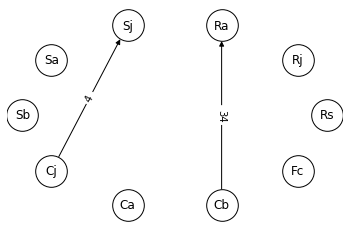

<Figure size 432x288 with 0 Axes>

In [57]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot

Arguments: Namespace(cuda=False, data=['data/EBT_0_20_dataset_3650.csv'], dilation_coefficient=4, early_stopping=True, epochs=2000, hidden_layers=2, kernel_size=4, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=37519, train_test_split=0.8)

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 1.263149
Epoch    15: reducing learning rate of group 0 to 1.0000e-02.
Epoch    26: reducing learning rate of group 0 to 1.0000e-03.
Epoch    37: reducing learning rate of group 0 to 1.0000e-04.
Epoch    48: reducing learning rate of group 0 to 1.0000e-05.
Epoch    59: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 250 [12%] 	Loss: 0.038894
Epoch: 500 [25%] 	Loss: 0.038861
INFO: Early stopping

 Analysis started for target:  Rj
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 1.237740
Epoch   141: reducing learning rat

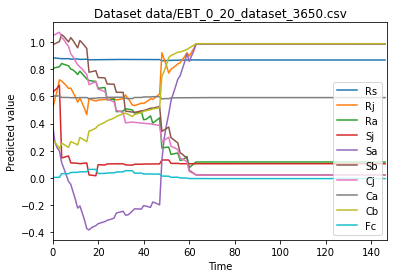

<Figure size 432x288 with 0 Axes>

In [58]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot --train_test_split 0.8

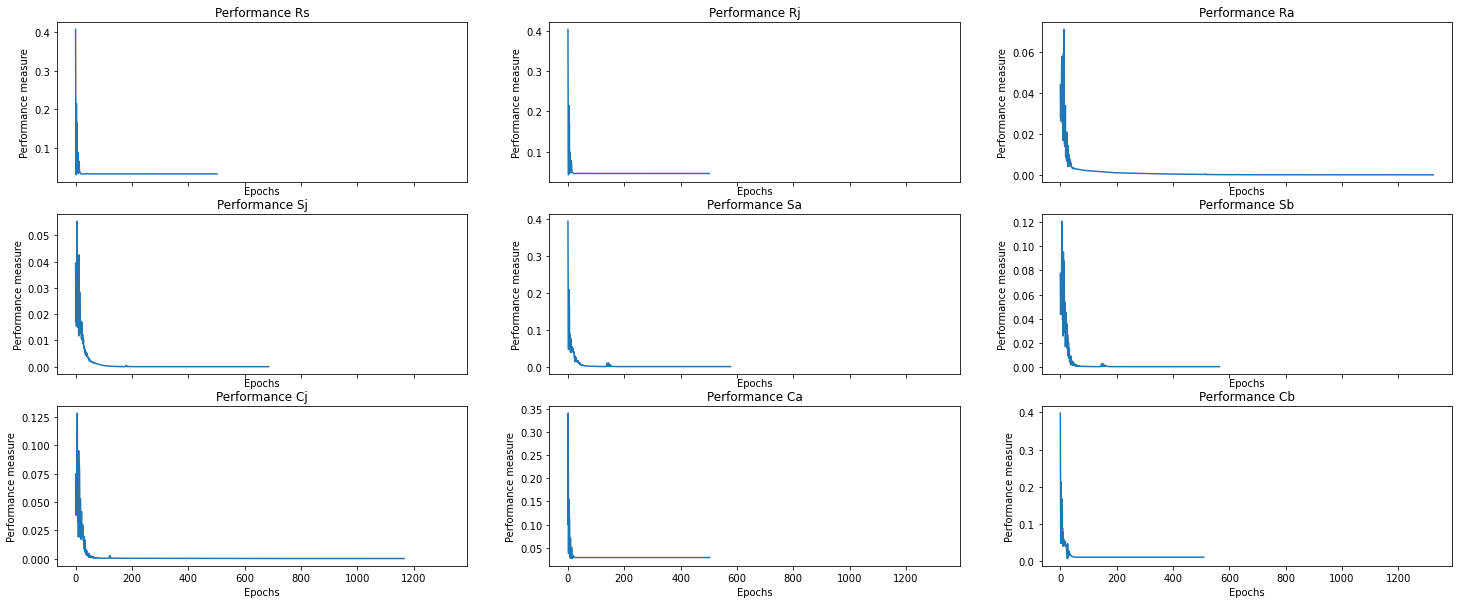

In [59]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

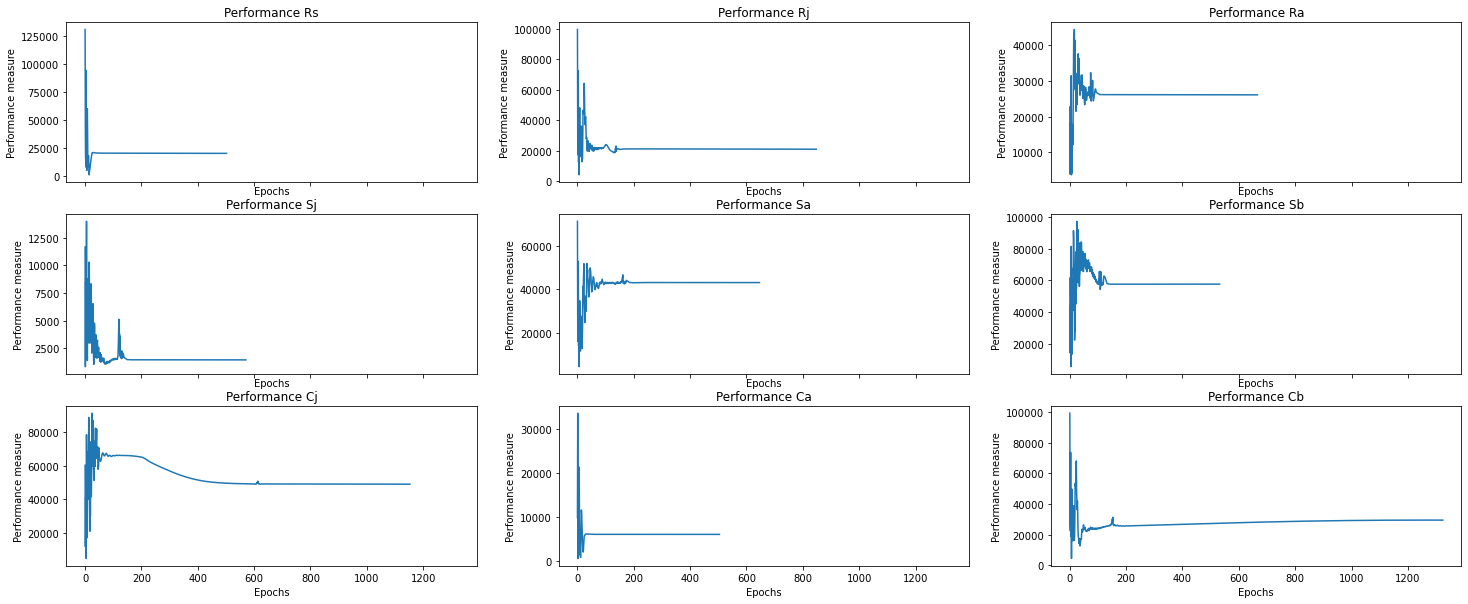

In [60]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

Arguments: Namespace(cuda=False, data=None, dilation_coefficient=4, early_stopping=True, epochs=2000, ground_truth={'data/EBT_0_20_dataset_3650.csv': 'data/EBT_demo_groundtruth.csv'}, hidden_layers=2, kernel_size=4, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=49741, significance=0.9)

 Dataset:  EBT_0_20_dataset_3650.csv

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 1.185915
Epoch    17: reducing learning rate of group 0 to 1.0000e-02.
Epoch: 250 [12%] 	Loss: 0.000810
Epoch: 500 [25%] 	Loss: 0.000540
Epoch: 750 [38%] 	Loss: 0.000433
Epoch   973: reducing learning rate of group 0 to 1.0000e-03.
Epoch: 1000 [50%] 	Loss: 0.000358
Epoch: 1250 [62%] 	Loss: 0.000336
Epoch: 1500 [75%] 	Loss: 0.000322
INFO: Early stopping
Potential causes:  [4, 5]
Validated causes:  []

 Analysis started for target:  Rj
INFO: Initializing learning rate scheduler
INFO: Initializi

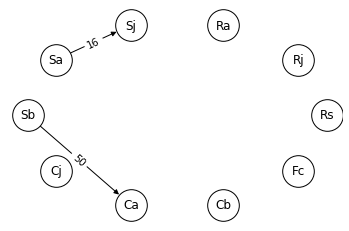

<Figure size 432x288 with 0 Axes>

In [61]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 49741 --plot

Arguments: Namespace(cuda=False, data=['data/EBT_0_20_dataset_3650.csv'], dilation_coefficient=4, early_stopping=True, epochs=2000, hidden_layers=2, kernel_size=4, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=49741, train_test_split=0.8)

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 1.155579
Epoch    18: reducing learning rate of group 0 to 1.0000e-02.
Epoch    29: reducing learning rate of group 0 to 1.0000e-03.
Epoch: 250 [12%] 	Loss: 0.001661
Epoch: 500 [25%] 	Loss: 0.000726
Epoch: 750 [38%] 	Loss: 0.000527
Epoch: 1000 [50%] 	Loss: 0.000437
Epoch: 1250 [62%] 	Loss: 0.000363
Epoch: 1500 [75%] 	Loss: 0.000283
Epoch: 1750 [88%] 	Loss: 0.000246
Epoch: 2000 [100%] 	Loss: 0.000221

 Analysis started for target:  Rj
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 1.132164
Epoch    18: reducing learning rate o

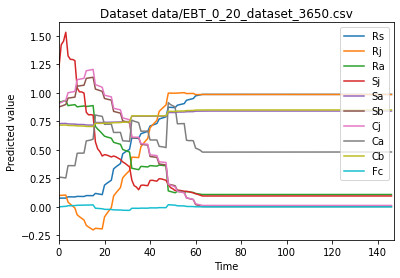

<Figure size 432x288 with 0 Axes>

In [62]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 49741 --plot --train_test_split 0.8

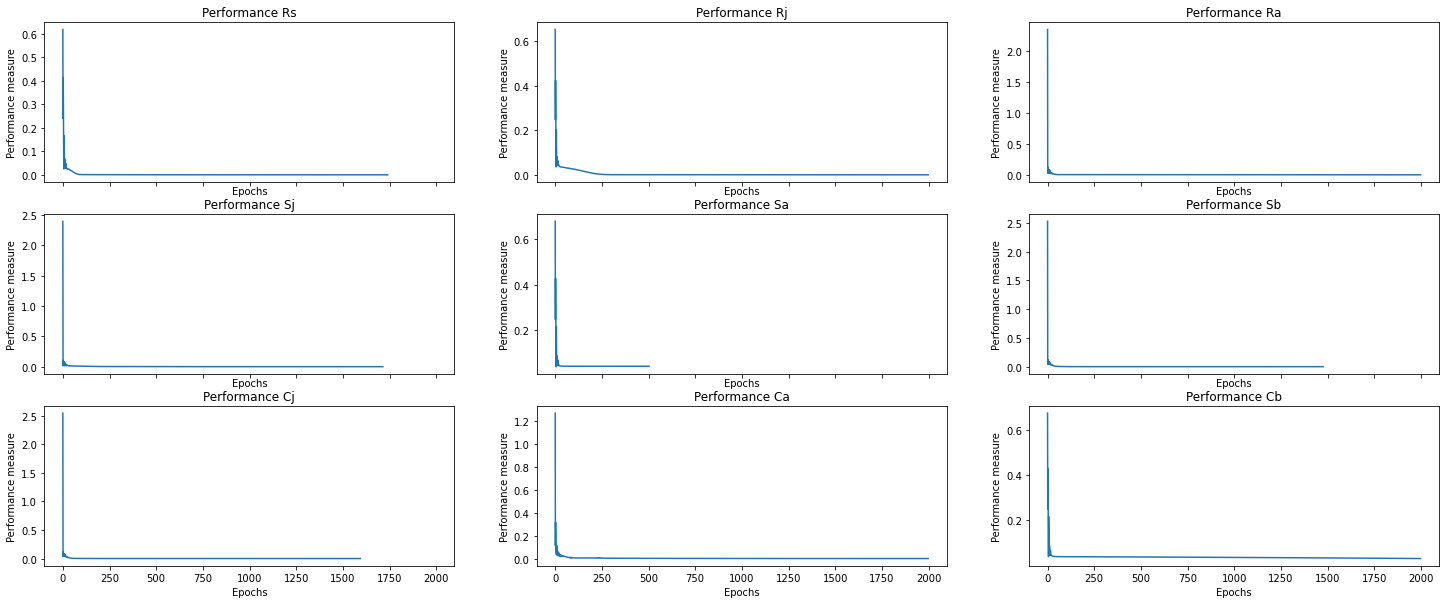

In [63]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

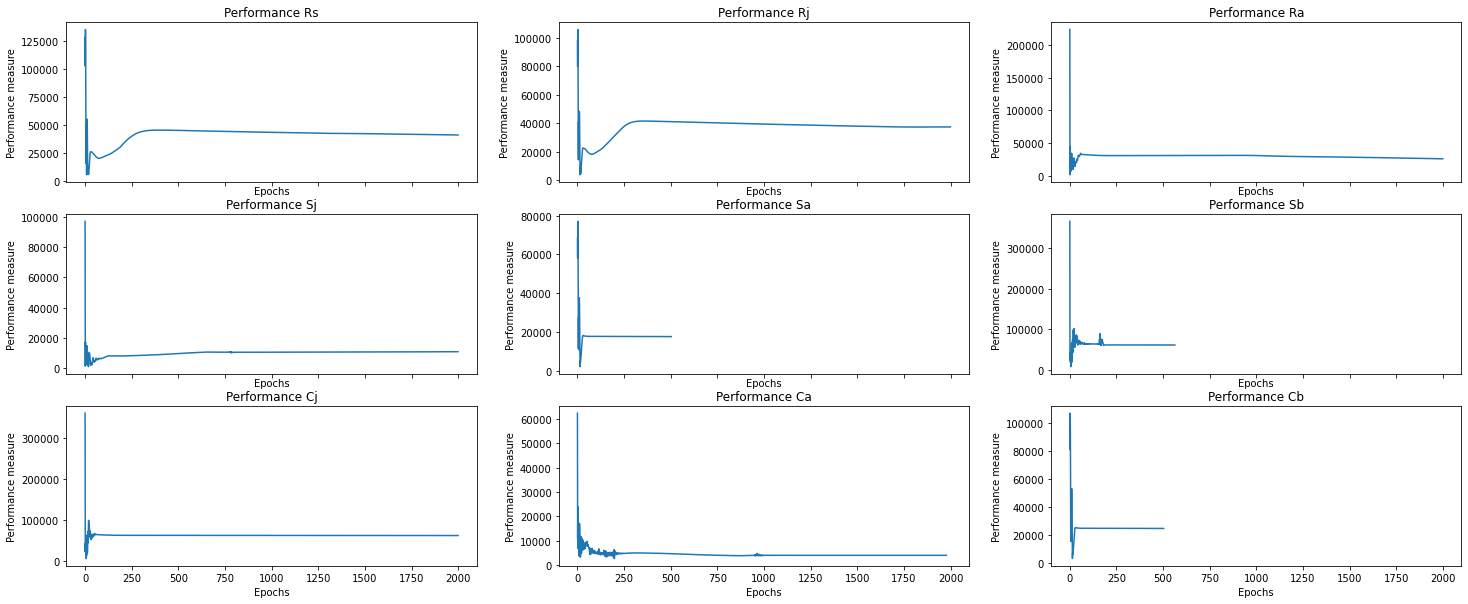

In [64]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

Arguments: Namespace(cuda=False, data=None, dilation_coefficient=4, early_stopping=True, epochs=2000, ground_truth={'data/EBT_0_20_dataset_3650.csv': 'data/EBT_demo_groundtruth.csv'}, hidden_layers=2, kernel_size=4, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=37786, significance=0.9)

 Dataset:  EBT_0_20_dataset_3650.csv

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.645226
Epoch    67: reducing learning rate of group 0 to 1.0000e-02.
Epoch    78: reducing learning rate of group 0 to 1.0000e-03.
Epoch    89: reducing learning rate of group 0 to 1.0000e-04.
Epoch   100: reducing learning rate of group 0 to 1.0000e-05.
Epoch   111: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 250 [12%] 	Loss: 0.004775
Epoch: 500 [25%] 	Loss: 0.004739
INFO: Early stopping
Potential causes:  [2, 8, 1]
Validated causes:  []

 Analysis started for target:  Rj
INFO:

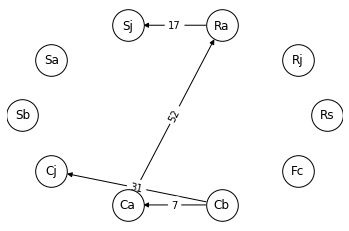

<Figure size 432x288 with 0 Axes>

In [65]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37786 --plot

Arguments: Namespace(cuda=False, data=['data/EBT_0_20_dataset_3650.csv'], dilation_coefficient=4, early_stopping=True, epochs=2000, hidden_layers=2, kernel_size=4, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=37786, train_test_split=0.8)

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.624970
Epoch    34: reducing learning rate of group 0 to 1.0000e-02.
Epoch: 250 [12%] 	Loss: 0.000406
Epoch   387: reducing learning rate of group 0 to 1.0000e-03.
Epoch: 500 [25%] 	Loss: 0.000300
Epoch: 750 [38%] 	Loss: 0.000283
Epoch: 1000 [50%] 	Loss: 0.000264
INFO: Early stopping

 Analysis started for target:  Rj
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.612633
Epoch   137: reducing learning rate of group 0 to 1.0000e-02.
Epoch: 250 [12%] 	Loss: 0.000175
Epoch: 500 [25%] 	Loss: 0.000128
Epoch: 750 [38%] 	Loss: 0

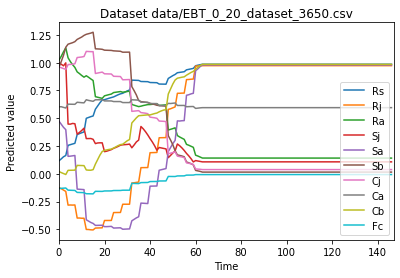

<Figure size 432x288 with 0 Axes>

In [66]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37786 --plot --train_test_split 0.8

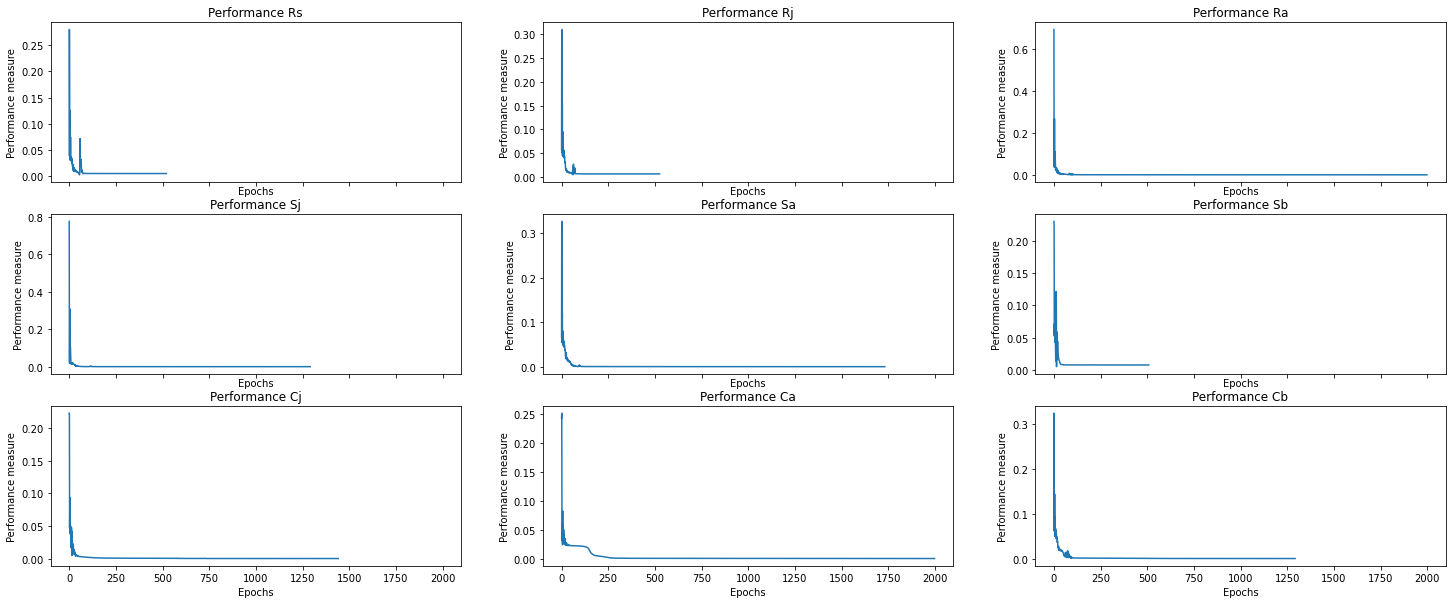

In [67]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

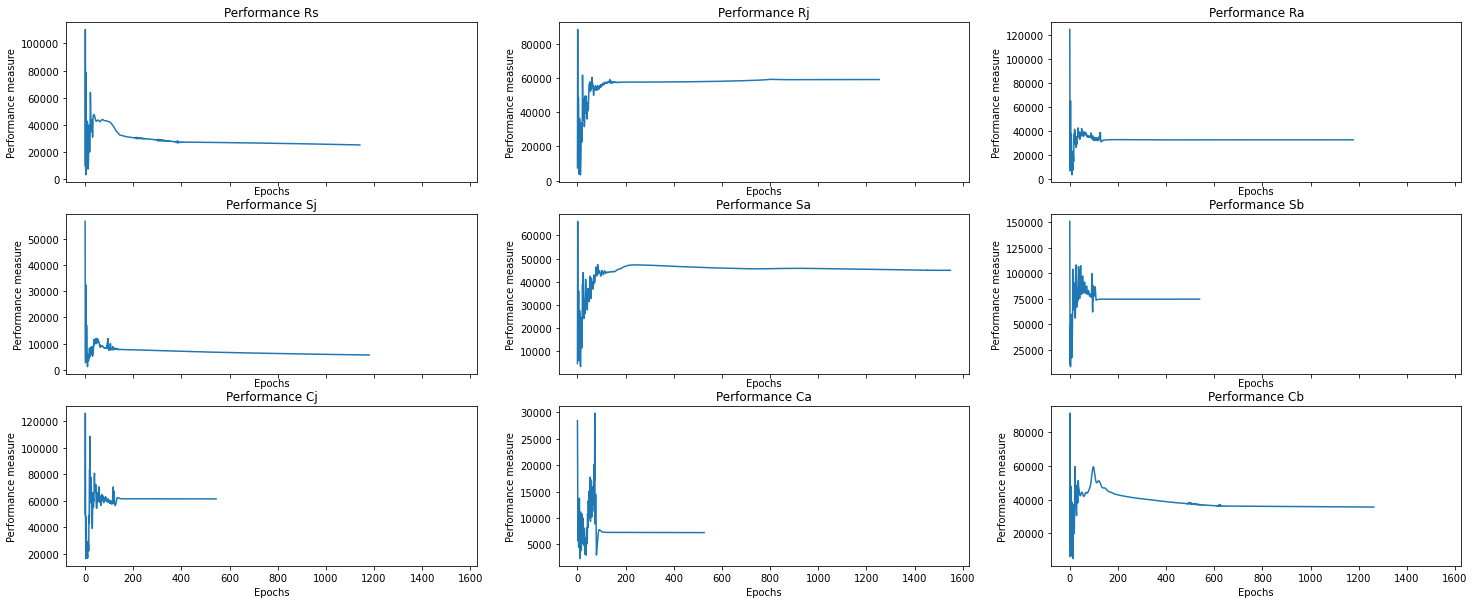

In [68]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 0-20 years: second run (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

Arguments: Namespace(cuda=False, data=None, dilation_coefficient=3, early_stopping=True, epochs=2000, ground_truth={'data/EBT_0_20_dataset_3650.csv': 'data/EBT_demo_groundtruth.csv'}, hidden_layers=3, kernel_size=3, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=94139, significance=0.9)

 Dataset:  EBT_0_20_dataset_3650.csv

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.331258
Epoch   173: reducing learning rate of group 0 to 1.0000e-02.
Epoch   184: reducing learning rate of group 0 to 1.0000e-03.
Epoch   195: reducing learning rate of group 0 to 1.0000e-04.
Epoch   206: reducing learning rate of group 0 to 1.0000e-05.
Epoch   217: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 250 [12%] 	Loss: 0.000328
Epoch: 500 [25%] 	Loss: 0.000328
INFO: Early stopping
Potential causes:  [6, 5, 8, 3]
Validated causes:  []

 Analysis started for target:  Rj
IN

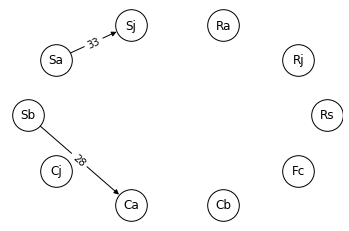

<Figure size 432x288 with 0 Axes>

In [69]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 94139 --plot


Arguments: Namespace(cuda=False, data=['data/EBT_0_20_dataset_3650.csv'], dilation_coefficient=3, early_stopping=True, epochs=2000, hidden_layers=3, kernel_size=3, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=94139, train_test_split=0.8)

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.319120
Epoch   167: reducing learning rate of group 0 to 1.0000e-02.
Epoch   178: reducing learning rate of group 0 to 1.0000e-03.
Epoch   189: reducing learning rate of group 0 to 1.0000e-04.
Epoch   200: reducing learning rate of group 0 to 1.0000e-05.
Epoch   211: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 250 [12%] 	Loss: 0.000409
Epoch: 500 [25%] 	Loss: 0.000409
INFO: Early stopping

 Analysis started for target:  Rj
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.315929
Epoch   224: reducing learning rat

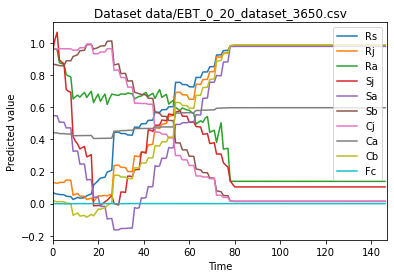

<Figure size 432x288 with 0 Axes>

In [70]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 94139 --plot --train_test_split 0.8

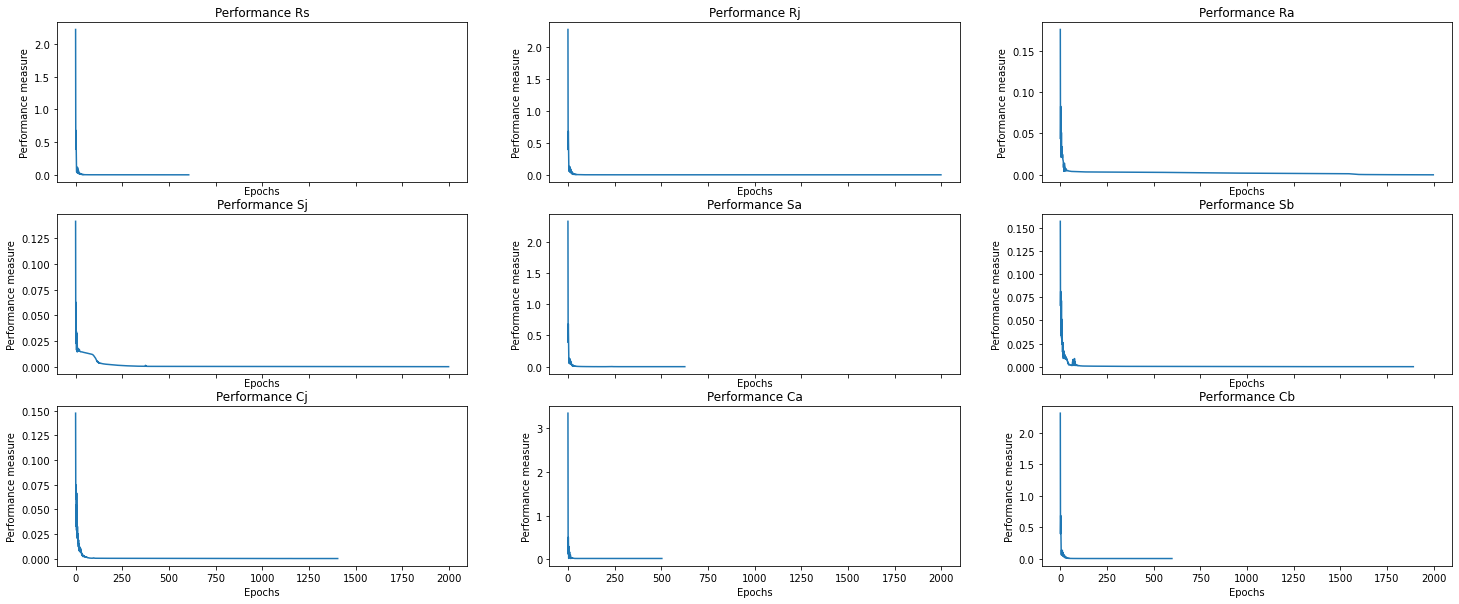

In [71]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

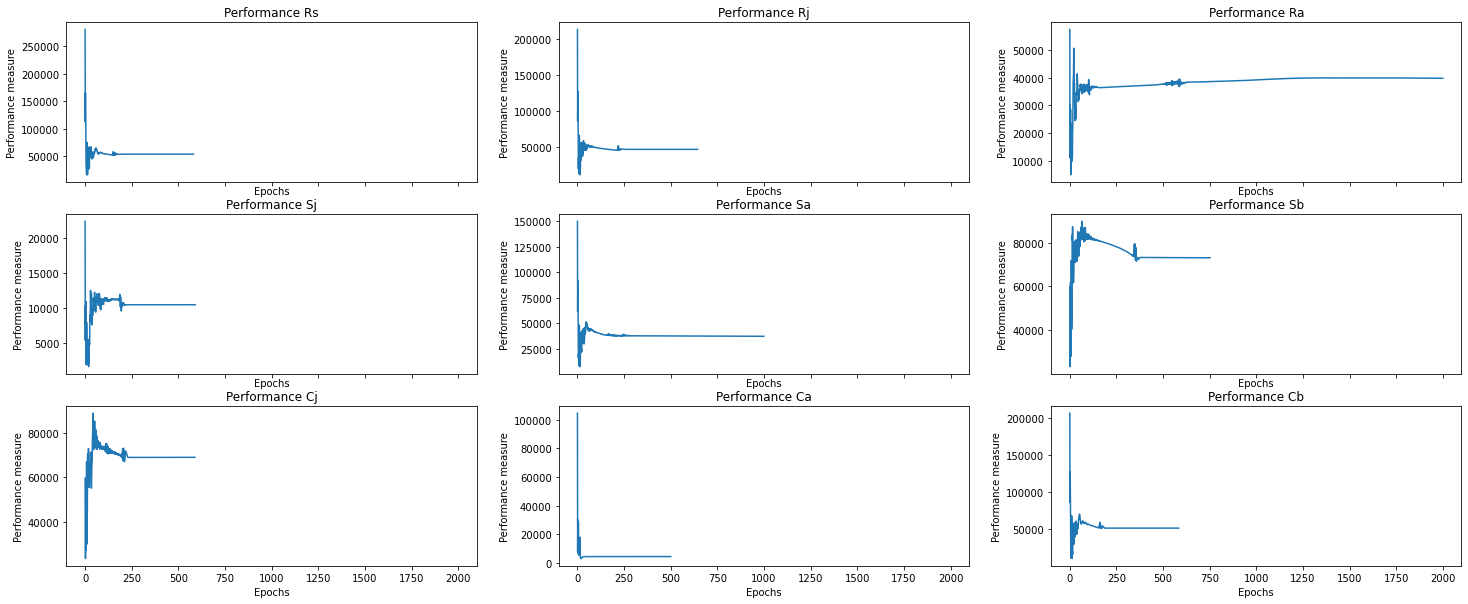

In [72]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

Arguments: Namespace(cuda=False, data=None, dilation_coefficient=3, early_stopping=True, epochs=2000, ground_truth={'data/EBT_0_20_dataset_3650.csv': 'data/EBT_demo_groundtruth.csv'}, hidden_layers=3, kernel_size=3, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=18147, significance=0.9)

 Dataset:  EBT_0_20_dataset_3650.csv

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 1.105701
Epoch    14: reducing learning rate of group 0 to 1.0000e-02.
Epoch    25: reducing learning rate of group 0 to 1.0000e-03.
Epoch    36: reducing learning rate of group 0 to 1.0000e-04.
Epoch    47: reducing learning rate of group 0 to 1.0000e-05.
Epoch    58: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 250 [12%] 	Loss: 0.044688
Epoch: 500 [25%] 	Loss: 0.044248
INFO: Early stopping
Potential causes:  [6, 9, 3, 7, 5]
Validated causes:  []

 Analysis started for target:  Rj

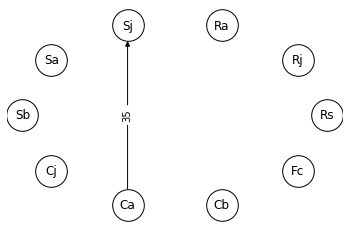

<Figure size 432x288 with 0 Axes>

In [73]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 18147 --plot


Arguments: Namespace(cuda=False, data=['data/EBT_0_20_dataset_3650.csv'], dilation_coefficient=3, early_stopping=True, epochs=2000, hidden_layers=3, kernel_size=3, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=18147, train_test_split=0.8)

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 1.076629
Epoch    15: reducing learning rate of group 0 to 1.0000e-02.
Epoch    26: reducing learning rate of group 0 to 1.0000e-03.
Epoch    37: reducing learning rate of group 0 to 1.0000e-04.
Epoch    48: reducing learning rate of group 0 to 1.0000e-05.
Epoch    59: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 250 [12%] 	Loss: 0.048744
Epoch: 500 [25%] 	Loss: 0.048119
INFO: Early stopping

 Analysis started for target:  Rj
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 1.054753
Epoch    15: reducing learning rat

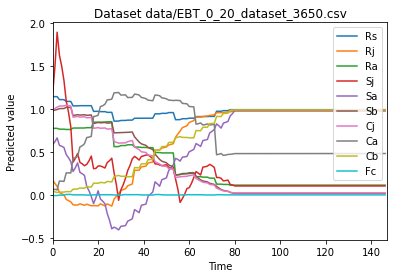

<Figure size 432x288 with 0 Axes>

In [74]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 18147 --plot --train_test_split 0.8

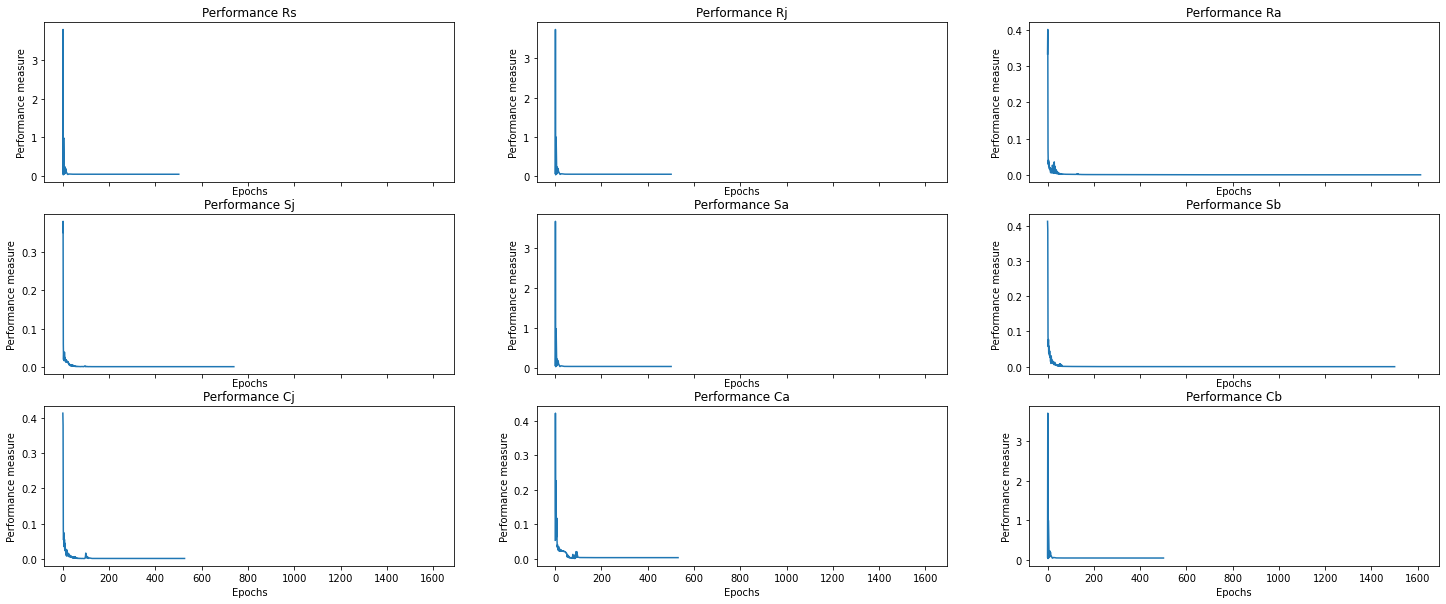

In [75]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

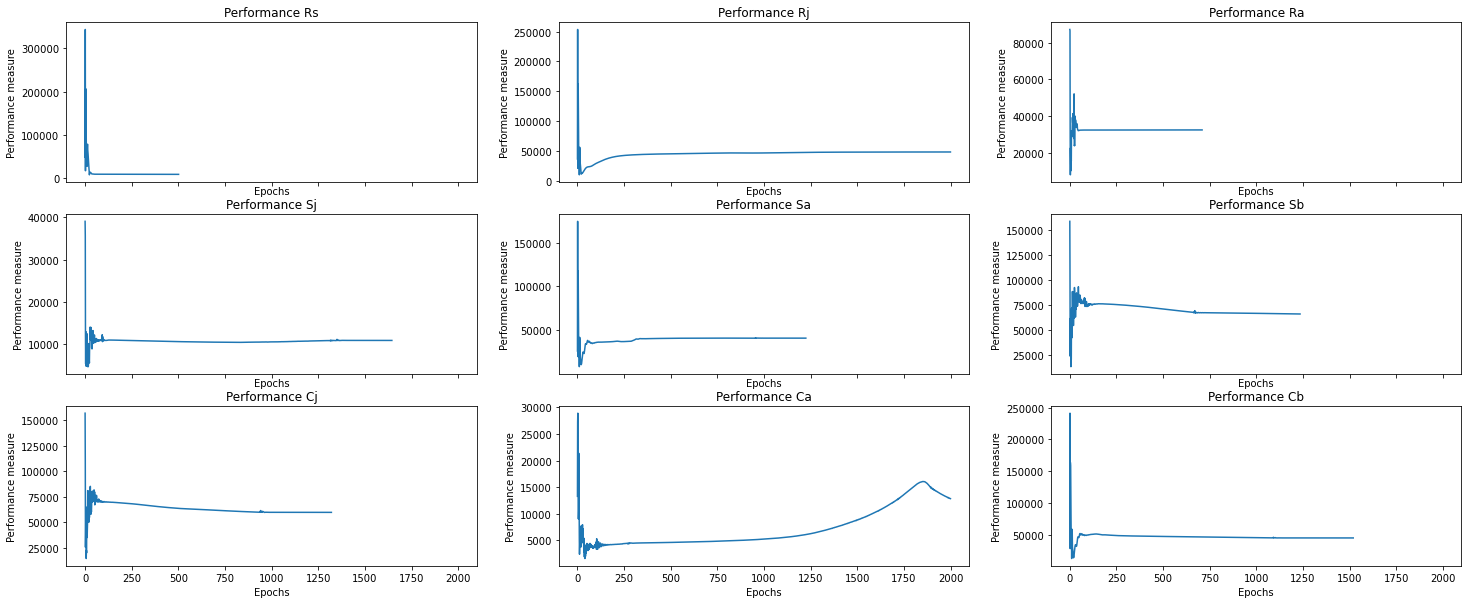

In [76]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

Arguments: Namespace(cuda=False, data=None, dilation_coefficient=3, early_stopping=True, epochs=2000, ground_truth={'data/EBT_0_20_dataset_3650.csv': 'data/EBT_demo_groundtruth.csv'}, hidden_layers=3, kernel_size=3, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=69089, significance=0.9)

 Dataset:  EBT_0_20_dataset_3650.csv

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.919056
Epoch   112: reducing learning rate of group 0 to 1.0000e-02.
Epoch   123: reducing learning rate of group 0 to 1.0000e-03.
Epoch   134: reducing learning rate of group 0 to 1.0000e-04.
Epoch   145: reducing learning rate of group 0 to 1.0000e-05.
Epoch   156: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 250 [12%] 	Loss: 0.000948
Epoch: 500 [25%] 	Loss: 0.000944
INFO: Early stopping
Potential causes:  [5, 1]
Validated causes:  []

 Analysis started for target:  Rj
INFO: In

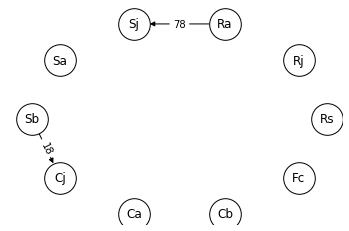

<Figure size 432x288 with 0 Axes>

In [77]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 69089 --plot


Arguments: Namespace(cuda=False, data=['data/EBT_0_20_dataset_3650.csv'], dilation_coefficient=3, early_stopping=True, epochs=2000, hidden_layers=3, kernel_size=3, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=69089, train_test_split=0.8)

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.893337
Epoch    33: reducing learning rate of group 0 to 1.0000e-02.
Epoch: 250 [12%] 	Loss: 0.001318
Epoch: 500 [25%] 	Loss: 0.000406
Epoch: 750 [38%] 	Loss: 0.000314
Epoch   981: reducing learning rate of group 0 to 1.0000e-03.
Epoch: 1000 [50%] 	Loss: 0.000126
Epoch: 1250 [62%] 	Loss: 0.000119
Epoch: 1500 [75%] 	Loss: 0.000112
INFO: Early stopping

 Analysis started for target:  Rj
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.874926
Epoch    86: reducing learning rate of group 0 to 1.0000e-02.
Epoch    97: reducing l

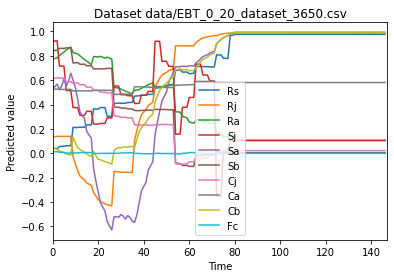

<Figure size 432x288 with 0 Axes>

In [78]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 69089 --plot --train_test_split 0.8

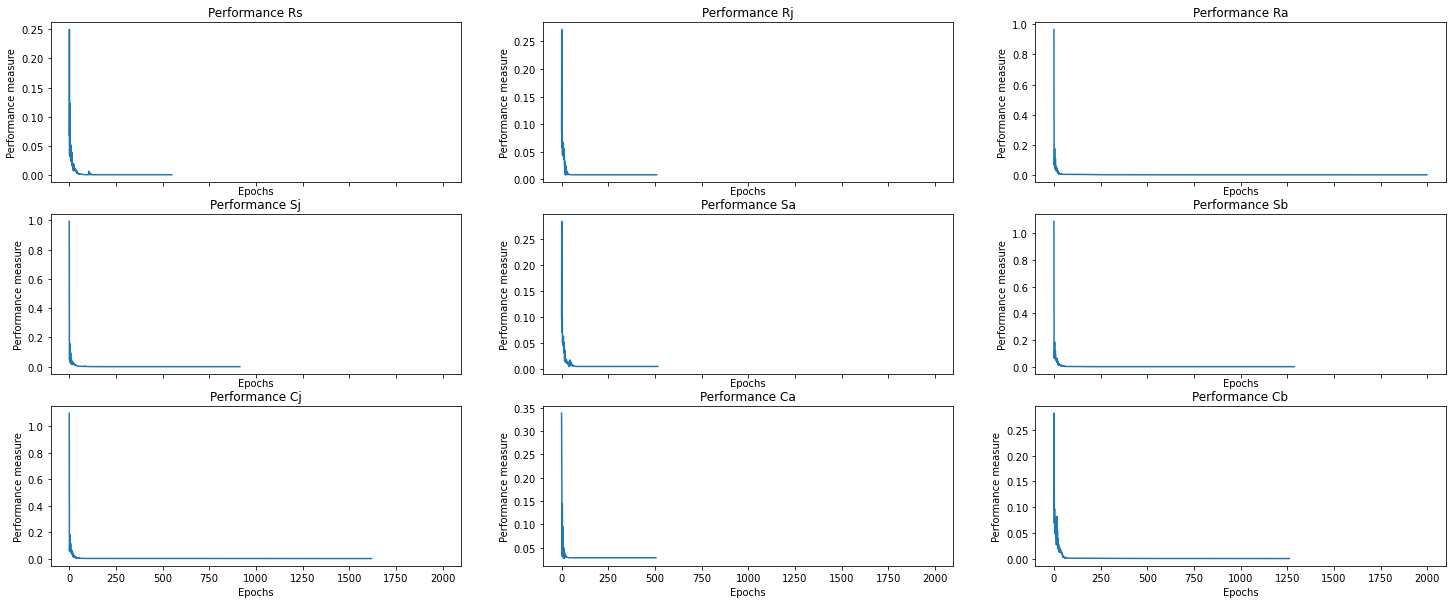

In [79]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

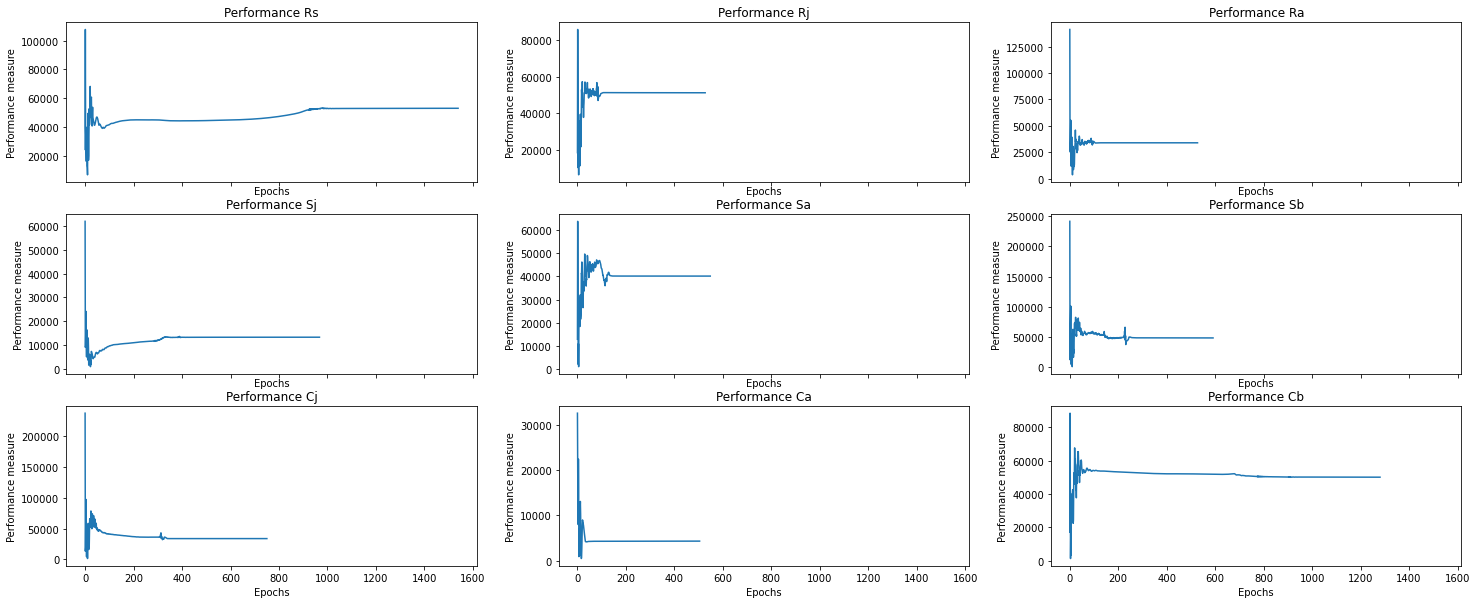

In [80]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 70 - 100 years

Rs        Rj        Ra            Sj        Sa            Sb  \
0     0.000000  0.000000  0.000000  1.000000e+00  0.000000  1.000000e+00   
1     0.009923  0.013226  0.004870  9.870535e-01  0.012832  9.872039e-01   
2     0.019787  0.026280  0.010552  9.742708e-01  0.025505  9.745666e-01   
3     0.029591  0.039163  0.015422  9.616501e-01  0.038019  9.620862e-01   
4     0.039333  0.051878  0.020292  9.491892e-01  0.050377  9.497609e-01   
...        ...       ...       ...           ...       ...           ...   
1081  0.999887  0.999999  1.000000  1.049690e-06  0.999999  6.692728e-07   
1082  0.999887  0.999999  1.000000  9.725473e-07  0.999999  6.195244e-07   
1083  0.999887  0.999999  1.000000  8.954047e-07  0.999999  5.700614e-07   
1084  0.999887  0.999999  1.000000  8.182622e-07  0.999999  5.208837e-07   
1085  0.999887  0.999999  1.000000  7.411196e-07  0.999999  4.719914e-07   

                Cj        Ca        Cb   Fc  
0     1.000000e+00  1.000000  1.000000  0.0  
1     9.866660e-01  0.994677  0.995720  0.0  
2     9.735087e-01  0.989382  0.991452  0.0  
3     9.605259e-01  0.984116  0.987197  0.0  
4     9.477152e-01  0.978876  0.982954  0.0  
...            ...       ...       ...  ...  
1081  1.317408e-06  0.000229  0.000280  0.0  
1082  1.219740e-06  0.000212  0.000259  0.0  
1083  1.122630e-06  0.000195  0.000238  0.0  
1084  1.026084e-06  0.000178  0.000218  0.0  
1085  9.300929e-07  0.000162  0.000198  0.0  

[1086 rows x 10 columns]

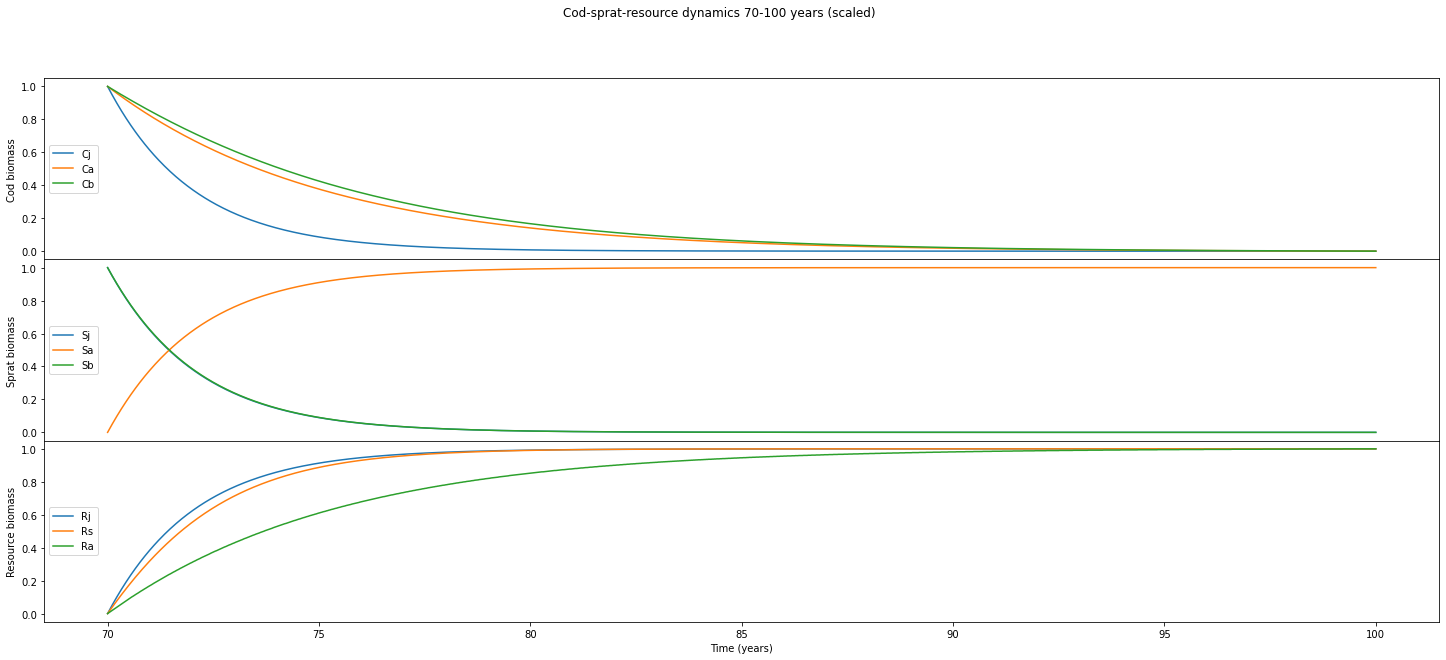

In [81]:
# Select data between 0 and 100 years
ebt_70_100 = select_data(ebt, 70, 100)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'EBT_70_100_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
ebt_70_100.to_csv(EBTScaled_path, index = False)

#### TCDF 70-100: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 34321 --plot

Arguments: Namespace(cuda=False, data=None, dilation_coefficient=4, early_stopping=True, epochs=2000, ground_truth={'data/EBT_70_100_dataset_3650.csv': 'data/EBT_demo_groundtruth.csv'}, hidden_layers=2, kernel_size=4, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=34321, significance=0.9)

 Dataset:  EBT_70_100_dataset_3650.csv

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.778184
Epoch: 250 [12%] 	Loss: 0.000081
Epoch   420: reducing learning rate of group 0 to 1.0000e-02.
Epoch   431: reducing learning rate of group 0 to 1.0000e-03.
Epoch   442: reducing learning rate of group 0 to 1.0000e-04.
Epoch   453: reducing learning rate of group 0 to 1.0000e-05.
Epoch   464: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 500 [25%] 	Loss: 0.000049
Epoch: 750 [38%] 	Loss: 0.000044
INFO: Early stopping
Potential causes:  [3, 2]
Validated causes:  []

 Anal

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 34321 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 85672 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 85672 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 63109 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 63109 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 70-100: second run  (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1238 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1238 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 53988 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 53988 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 92422 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 92422 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

### TCDF with EBT transient dynamics

This data represents the tritrophic biomasses during the introduced fishing pressure on cod. At 20 years Fc increases and is put to a halt on 40 years. Therefore I split the transient dynamics into two separate transient phases: 20-40 years (fishing pressure increases linearly) and 40-70 years (searching for a new equilibrium).

#### 20 - 60 years

In [ ]:
# Select data between 20 and 60 years
ebt_20_60 = select_data(ebt, 20, 60)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'EBT_20_60_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
ebt_20_60.to_csv(EBTScaled_path, index = False)

#### TCDF 20-60 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 24310 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 24310 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 77139 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 77139 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 45184 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 45184 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 20-60 years: second run  (decreased hidden layers by 1, increased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 78025 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 78025 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 53391 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 53391 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 34061 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 34061 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 60 - 70 years

In [ ]:
# Select data between 60 and 70 years
ebt_60_70 = select_data(ebt, 60, 70)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'EBT_60_70_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
ebt_60_70.to_csv(EBTScaled_path, index = False)

#### TCDF 60-70 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 2369 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 2369 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 33520 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 33520 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 66848 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 66848 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 60-70 years: second run  (decreased hidden layers by 1, increased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 2369 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 2369 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 21312 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 21312 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 8023 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 8023 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

## TCDF: Noisy Data

Same exact models are run with noisy data.

### Adding white noise (Additive White Gaussian Noise)

Training the model with additive noise might be helpful in avoiding overfitting of the model. Data in this section is augmented by adding noise with additive white Gaussian noise. Three different datasets are provided - SNR 1:0.1, 1:1, 1:10. Each noisy dataset is analysed with optimized (hyper)parameters for the particular dataset to increase performance and accuracy.

### Signal to Noise ratio 1:0.1

In [ ]:
# Create new dataset with snr 1:0.1
noisy_ebt = noisy_data(10)

#### 20 - 70 years

In [ ]:
# Select data between 20 and 70 years
noisy_ebt_20_70 = select_data(noisy_ebt, 20, 70)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, '1_0.1_noisy_EBT_20_70_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_20_70.to_csv(EBTScaled_path, index = False)

#### TCDF 20-70 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 5678


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 5467 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 2371


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 2371 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1084


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1048 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 20-70 years: second run (decreased hidden layers by 1, incremented dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 5467


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 5467 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 9238


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 9238 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 157


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 157 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 0 - 100 years

In [ ]:
# Select data between 0 and 100 years
noisy_ebt_0_100 = select_data(noisy_ebt, 0, 100)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, '1_0.1_noisy_EBT_0_100_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_0_100.to_csv(EBTScaled_path, index = False)

#### TCDF 0-100 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37519

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 15787

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 15787 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 74326

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 74326 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

#### TCDF 0-100 years: second run (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1111

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1111 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 18040

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 18040 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 86547

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 86547 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

#### 0 - 20 years

In [ ]:
# Select data between 0 and 20 years
noisy_ebt_0_20 = select_data(noisy_ebt, 0, 20)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, '1_0.1_noisy_EBT_0_20_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_0_20.to_csv(EBTScaled_path, index = False)

#### TCDF 0 - 20 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37519

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 49741

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 49741 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37786

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37786 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 0-20 years: second run (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 94139


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 94139 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 18147


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 18147 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 69089


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 69089 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 70 - 100 years

In [ ]:
# Select data between 70 and 100 years
noisy_ebt_70_100 = select_data(noisy_ebt, 70, 100)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, '1_0.1_noisy_EBT_70_100_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_70_100.to_csv(EBTScaled_path, index = False)

#### TCDF 70-100: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 34321

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 34321 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 85672

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 85672 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 63109

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 63109 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 70-100: second run  (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1238

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1238 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 53988

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 53988 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 92422

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 92422 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 20 - 60 years

In [ ]:
# Select data between 20 and 60 years
noisy_ebt_20_60 = select_data(noisy_ebt, 20, 60)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, '1_0.1_noisy_EBT_20_60_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_20_60.to_csv(EBTScaled_path, index = False)

#### TCDF 20-60 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 24310

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 24310 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 77139

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 77139 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 45184

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 45184 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 20-60 years: second run  (decreased hidden layers by 1, increased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 78025

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 78025 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 53391

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 53391 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 34061

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 34061 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 60 - 70 years

In [ ]:
# Select data between 20 and 60 years
noisy_ebt_60_70 = select_data(noisy_ebt, 60, 70)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, '1_0.1_noisy_EBT_60_70_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_60_70.to_csv(EBTScaled_path, index = False)

#### TCDF 60-70 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 2369

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 2369 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 33520

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 33520 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 66848

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 66848 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 60-70 years: second run  (decreased hidden layers by 1, increased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 2369

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 2369 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 21312

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 21312 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 8023

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 8023 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

### Signal to Noise ratio 1:1

In [ ]:
# Create new dataset with snr 1:1
noisy_ebt = noisy_data(1)

#### 20 - 70 years

In [ ]:
# Select data between 20 and 70 years
noisy_ebt_20_70 = select_data(noisy_ebt, 20, 70)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, '1_1_noisy_EBT_20_70_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_20_70.to_csv(EBTScaled_path, index = False)

#### TCDF 20-70 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 5678


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 5467 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 2371


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 2371 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1084


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1048 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 20-70 years: second run (decreased hidden layers by 1, incremented dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 5467


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 5467 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 9238


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 9238 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 157


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 157 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 0 - 100 years

In [ ]:
# Select data between 0 and 100 years
noisy_ebt_0_100 = select_data(noisy_ebt, 0, 100)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, '1_1_noisy_EBT_0_100_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_0_100.to_csv(EBTScaled_path, index = False)

#### TCDF 0-100 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37519

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 15787

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 15787 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 74326

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 74326 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

#### TCDF 0-100 years: second run (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1111

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1111 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 18040

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 18040 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 86547

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 86547 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

#### 0 - 20 years

In [ ]:
# Select data between 0 and 20 years
noisy_ebt_0_20 = select_data(noisy_ebt, 0, 20)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, '1_1_noisy_EBT_0_20_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_0_20.to_csv(EBTScaled_path, index = False)

#### TCDF 0 - 20 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37519

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 49741

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 49741 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37786

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37786 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 0-20 years: second run (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 94139


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 94139 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 18147


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 18147 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 69089


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 69089 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 70 - 100 years

In [ ]:
# Select data between 70 and 100 years
noisy_ebt_70_100 = select_data(noisy_ebt, 70, 100)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, '1_1_noisy_EBT_70_100_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_70_100.to_csv(EBTScaled_path, index = False)

#### TCDF 70-100: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 34321

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 34321 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 85672

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 85672 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 63109

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 63109 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 70-100: second run  (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1238

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1238 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 53988

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 53988 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 92422

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 92422 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 20 - 60 years

In [ ]:
# Select data between 20 and 60 years
noisy_ebt_20_60 = select_data(noisy_ebt, 20, 60)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, '1_1_noisy_EBT_20_60_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_20_60.to_csv(EBTScaled_path, index = False)

#### TCDF 20-60 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 24310

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 24310 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 77139

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 77139 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 45184

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 45184 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 20-60 years: second run  (decreased hidden layers by 1, increased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 78025

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 78025 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 53391

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 53391 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 34061

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 34061 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 60 - 70 years

In [ ]:
# Select data between 20 and 60 years
noisy_ebt_60_70 = select_data(noisy_ebt, 60, 70)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, '1_1_noisy_EBT_60_70_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_60_70.to_csv(EBTScaled_path, index = False)

#### TCDF 60-70 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 2369

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 2369 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 33520

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 33520 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 66848

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 66848 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 60-70 years: second run  (decreased hidden layers by 1, increased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 2369

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 2369 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 21312

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 21312 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 8023

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 8023 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

### Signal to Noise ratio 1:10

In [ ]:
# Create new dataset with snr 1:10
noisy_ebt = noisy_data(0.1)

#### 20 - 70 years

In [ ]:
# Select data between 20 and 70 years
noisy_ebt_20_70 = select_data(noisy_ebt, 20, 70)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, '1_10_noisy_EBT_20_70_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_20_70.to_csv(EBTScaled_path, index = False)

#### TCDF 20-70 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 5678


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 5467 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 2371


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 2371 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1084


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1048 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 20-70 years: second run (decreased hidden layers by 1, incremented dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 5467


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 5467 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 9238


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 9238 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 157


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 157 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 0 - 100 years

In [ ]:
# Select data between 0 and 100 years
noisy_ebt_0_100 = select_data(noisy_ebt, 0, 100)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, '1_10_noisy_EBT_0_100_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_0_100.to_csv(EBTScaled_path, index = False)

#### TCDF 0-100 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37519

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 15787

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 15787 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 74326

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 74326 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

#### TCDF 0-100 years: second run (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1111

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1111 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 18040

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 18040 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 86547

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 86547 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

#### 0 - 20 years

In [ ]:
# Select data between 0 and 20 years
noisy_ebt_0_20 = select_data(noisy_ebt, 0, 20)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, '1_10_noisy_EBT_0_20_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_0_20.to_csv(EBTScaled_path, index = False)

#### TCDF 0 - 20 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37519

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 49741

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 49741 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37786

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37786 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 0-20 years: second run (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 94139


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 94139 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 18147


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 18147 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 69089


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 69089 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 70 - 100 years

In [ ]:
# Select data between 70 and 100 years
noisy_ebt_70_100 = select_data(noisy_ebt, 70, 100)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, '1_10_noisy_EBT_70_100_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_70_100.to_csv(EBTScaled_path, index = False)

#### TCDF 70-100: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 34321

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 34321 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 85672

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 85672 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 63109

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 63109 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 70-100: second run  (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1238

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1238 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 53988

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 53988 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 92422

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 92422 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 20 - 60 years

In [ ]:
# Select data between 20 and 60 years
noisy_ebt_20_60 = select_data(noisy_ebt, 20, 60)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, '1_10_noisy_EBT_20_60_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_20_60.to_csv(EBTScaled_path, index = False)

#### TCDF 20-60 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 24310

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 24310 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 77139

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 77139 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 45184

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 45184 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 20-60 years: second run  (decreased hidden layers by 1, increased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 78025

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 78025 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 53391

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 53391 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 34061

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 34061 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 60 - 70 years

In [ ]:
# Select data between 20 and 60 years
noisy_ebt_60_70 = select_data(noisy_ebt, 60, 70)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, '1_10_noisy_EBT_60_70_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_60_70.to_csv(EBTScaled_path, index = False)

#### TCDF 60-70 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 2369

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 2369 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 33520

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 33520 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 66848

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 66848 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 60-70 years: second run  (decreased hidden layers by 1, increased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 2369

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 2369 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 21312

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 21312 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 8023

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 8023 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)


## Power Transformation Scaling

### Signal to Noise ratio 1:0
### Resolution 3650

### TCDF with EBT total dynamics

This data represents the tritrophic biomasses including the total dynamics (shift change). The system first is at its equilibrium and remains stable for ~20 years, fishing pressure is introduced and a new equilibrium is to be found (at 70 years it is stable again). Data is split into two 'total dynamics', 0 - 100 years and 20 - 70 years respectively.

#### 20 - 70 years

In [ ]:
# Select data between 20 and 70 years
ebt_20_70 = select_data(ebt, 20, 70, 'power')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'power_EBT_20_70_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
ebt_20_70.to_csv(EBTScaled_path, index = False)

#### TCDF 20-70 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 5467 --plot


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 5467 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 2371 --plot


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 2371 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1084 --plot


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1048 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 20-70 years: second run (decreased hidden layers by 1, incremented dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 5467 --plot


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 5467 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 9238 --plot


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 9238 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 157 --plot


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 157 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 0 - 100 years

In [ ]:
# Select data between 0 and 100 years
ebt_0_100 = select_data(ebt, 0, 100, 'power')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'power_EBT_0_100_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
ebt_0_100.to_csv(EBTScaled_path, index = False)

#### TCDF 0-100 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 15787 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 15787 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 74326 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 74326 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

#### TCDF 0-100 years: second run (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1111 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1111 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 18040 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 18040 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 86547 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 86547 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

### TCDF with EBT equilibrium dynamics

This data represents the tritrophic biomasses before the introduced fishing pressure on cod. The system first finds it equilibrium and remains stable for ~20 years. Therefore, no relations should be found by the machine learning model.

#### 0 - 20 years

In [ ]:
# Select data between 0 and 20 years
ebt_0_20 = select_data(ebt, 0, 20, 'power')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'power_EBT_0_20_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
ebt_0_20.to_csv(EBTScaled_path, index = False)

#### TCDF 0 - 20 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 49741 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 49741 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37786 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37786 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 0-20 years: second run (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 94139 --plot


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 94139 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 18147 --plot


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 18147 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 69089 --plot


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 69089 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 70 - 100 years

In [ ]:
# Select data between 70 and 100 years
ebt_70_100 = select_data(ebt, 70, 100, 'power')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'power_EBT_70_100_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
ebt_70_100.to_csv(EBTScaled_path, index = False)

#### TCDF 70-100: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 34321 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 34321 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 85672 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 85672 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 63109 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 63109 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 70-100: second run  (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1238 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1238 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 53988 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 53988 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 92422 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 92422 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

### TCDF with EBT transient dynamics

This data represents the tritrophic biomasses during the introduced fishing pressure on cod. At 20 years Fc increases and is put to a halt on 40 years. Therefore I split the transient dynamics into two separate transient phases: 20-40 years (fishing pressure increases linearly) and 40-70 years (searching for a new equilibrium).

#### 20 - 60 years

In [ ]:
# Select data between 20 and 60 years
ebt_20_60 = select_data(ebt, 20, 60, 'power')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'power_EBT_20_60_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
ebt_20_60.to_csv(EBTScaled_path, index = False)

#### TCDF 20-60 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 24310 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 24310 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 77139 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 77139 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 45184 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 45184 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 20-60 years: second run  (decreased hidden layers by 1, increased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 78025 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 78025 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 53391 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 53391 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 34061 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 34061 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 60 - 70 years

In [ ]:
# Select data between 60 and 70 years
ebt_60_70 = select_data(ebt, 60, 70, 'power')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'power_EBT_60_70_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
ebt_60_70.to_csv(EBTScaled_path, index = False)

#### TCDF 60-70 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 2369 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 2369 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 33520 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 33520 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 66848 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 66848 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 60-70 years: second run  (decreased hidden layers by 1, increased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 2369 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 2369 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 21312 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 21312 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 8023 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 8023 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

## TCDF: Noisy Data

Same exact models are run with noisy data.

### Adding white noise (Additive White Gaussian Noise)

Training the model with additive noise might be helpful in avoiding overfitting of the model. Data in this section is augmented by adding noise with additive white Gaussian noise. Three different datasets are provided - SNR 1:0.1, 1:1, 1:10. Each noisy dataset is analysed with optimized (hyper)parameters for the particular dataset to increase performance and accuracy.

### Signal to Noise ratio 1:0.1

In [ ]:
# Create new dataset with snr 1:0.1
noisy_ebt = noisy_data(10)

#### 20 - 70 years

In [ ]:
# Select data between 20 and 70 years
noisy_ebt_20_70 = select_data(noisy_ebt, 20, 70, 'power')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'power_1_0.1_noisy_EBT_20_70_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_20_70.to_csv(EBTScaled_path, index = False)

#### TCDF 20-70 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 5678


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 5467 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 2371


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 2371 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1084


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1048 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 20-70 years: second run (decreased hidden layers by 1, incremented dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 5467


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 5467 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 9238


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 9238 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 157


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 157 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 0 - 100 years

In [ ]:
# Select data between 0 and 100 years
noisy_ebt_0_100 = select_data(noisy_ebt, 0, 100, 'power')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'power_1_0.1_noisy_EBT_0_100_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_0_100.to_csv(EBTScaled_path, index = False)

#### TCDF 0-100 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37519

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 15787

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 15787 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 74326

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 74326 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

#### TCDF 0-100 years: second run (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1111

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1111 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 18040

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 18040 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 86547

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 86547 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

#### 0 - 20 years

In [ ]:
# Select data between 0 and 20 years
noisy_ebt_0_20 = select_data(noisy_ebt, 0, 20, 'power')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'power_1_0.1_noisy_EBT_0_20_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_0_20.to_csv(EBTScaled_path, index = False)

#### TCDF 0 - 20 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37519

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 49741

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 49741 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37786

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37786 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 0-20 years: second run (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 94139


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 94139 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 18147


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 18147 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 69089


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 69089 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 70 - 100 years

In [ ]:
# Select data between 70 and 100 years
noisy_ebt_70_100 = select_data(noisy_ebt, 70, 100, 'power')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'power_1_0.1_noisy_EBT_70_100_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_70_100.to_csv(EBTScaled_path, index = False)

#### TCDF 70-100: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 34321

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 34321 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 85672

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 85672 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 63109

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 63109 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 70-100: second run  (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1238

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1238 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 53988

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 53988 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 92422

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 92422 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 20 - 60 years

In [ ]:
# Select data between 20 and 60 years
noisy_ebt_20_60 = select_data(noisy_ebt, 20, 60, 'power')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'power_1_0.1_noisy_EBT_20_60_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_20_60.to_csv(EBTScaled_path, index = False)

#### TCDF 20-60 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 24310

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 24310 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 77139

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 77139 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 45184

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 45184 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 20-60 years: second run  (decreased hidden layers by 1, increased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 78025

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 78025 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 53391

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 53391 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 34061

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 34061 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 60 - 70 years

In [ ]:
# Select data between 60 and 70 years
noisy_ebt_60_70 = select_data(noisy_ebt, 60, 70, 'power')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'power_1_0.1_noisy_EBT_60_70_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_60_70.to_csv(EBTScaled_path, index = False)

#### TCDF 60-70 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 2369

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 2369 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 33520

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 33520 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 66848

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 66848 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 60-70 years: second run  (decreased hidden layers by 1, increased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 2369

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 2369 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 21312

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 21312 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 8023

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 8023 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

### Signal to Noise ratio 1:1

In [ ]:
# Create new dataset with snr 1:1
noisy_ebt = noisy_data(1)

#### 20 - 70 years

In [ ]:
# Select data between 20 and 70 years
noisy_ebt_20_70 = select_data(noisy_ebt, 20, 70, 'power')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'power_1_1_noisy_EBT_20_70_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_20_70.to_csv(EBTScaled_path, index = False)

#### TCDF 20-70 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 5678


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 5467 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 2371


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 2371 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1084


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1048 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 20-70 years: second run (decreased hidden layers by 1, incremented dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 5467


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 5467 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 9238


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 9238 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 157


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 157 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 0 - 100 years

In [ ]:
# Select data between 0 and 100 years
noisy_ebt_0_100 = select_data(noisy_ebt, 0, 100, 'power')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'power_1_1_noisy_EBT_0_100_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_0_100.to_csv(EBTScaled_path, index = False)

#### TCDF 0-100 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37519

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 15787

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 15787 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 74326

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 74326 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

#### TCDF 0-100 years: second run (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1111

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1111 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 18040

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 18040 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 86547

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 86547 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

#### 0 - 20 years

In [ ]:
# Select data between 0 and 20 years
noisy_ebt_0_20 = select_data(noisy_ebt, 0, 20, 'power')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'power_1_1_noisy_EBT_0_20_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_0_20.to_csv(EBTScaled_path, index = False)

#### TCDF 0 - 20 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37519

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 49741

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 49741 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37786

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37786 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 0-20 years: second run (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 94139


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 94139 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 18147


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 18147 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 69089


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 69089 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 70 - 100 years

In [ ]:
# Select data between 70 and 100 years
noisy_ebt_70_100 = select_data(noisy_ebt, 70, 100, 'power')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'power_1_1_noisy_EBT_70_100_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_70_100.to_csv(EBTScaled_path, index = False)

#### TCDF 70-100: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 34321

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 34321 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 85672

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 85672 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 63109

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 63109 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 70-100: second run  (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1238

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1238 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 53988

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 53988 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 92422

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 92422 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 20 - 60 years

In [ ]:
# Select data between 20 and 60 years
noisy_ebt_20_60 = select_data(noisy_ebt, 20, 60, 'power')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'power_1_1_noisy_EBT_20_60_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_20_60.to_csv(EBTScaled_path, index = False)

#### TCDF 20-60 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 24310

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 24310 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 77139

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 77139 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 45184

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 45184 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 20-60 years: second run  (decreased hidden layers by 1, increased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 78025

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 78025 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 53391

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 53391 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 34061

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 34061 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 60 - 70 years

In [ ]:
# Select data between 60 and 70 years
noisy_ebt_60_70 = select_data(noisy_ebt, 60, 70, 'power')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'power_1_1_noisy_EBT_60_70_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_60_70.to_csv(EBTScaled_path, index = False)

#### TCDF 60-70 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 2369

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 2369 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 33520

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 33520 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 66848

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 66848 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 60-70 years: second run  (decreased hidden layers by 1, increased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 2369

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 2369 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 21312

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 21312 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 8023

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 8023 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

### Signal to Noise ratio 1:10

In [ ]:
# Create new dataset with snr 1:10
noisy_ebt = noisy_data(0.1)

#### 20 - 70 years

In [ ]:
# Select data between 20 and 70 years
noisy_ebt_20_70 = select_data(noisy_ebt, 20, 70, 'power')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'power_1_10_noisy_EBT_20_70_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_20_70.to_csv(EBTScaled_path, index = False)

#### TCDF 20-70 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 5678


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 5467 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 2371


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 2371 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1084


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1048 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 20-70 years: second run (decreased hidden layers by 1, incremented dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 5467


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 5467 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 9238


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 9238 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 157


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 157 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 0 - 100 years

In [ ]:
# Select data between 0 and 100 years
noisy_ebt_0_100 = select_data(noisy_ebt, 0, 100, 'power')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'power_1_10_noisy_EBT_0_100_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_0_100.to_csv(EBTScaled_path, index = False)

#### TCDF 0-100 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37519

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 15787

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 15787 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 74326

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 74326 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

#### TCDF 0-100 years: second run (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1111

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1111 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 18040

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 18040 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 86547

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 86547 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

#### 0 - 20 years

In [ ]:
# Select data between 0 and 20 years
noisy_ebt_0_20 = select_data(noisy_ebt, 0, 20, 'power')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'power_1_10_noisy_EBT_0_20_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_0_20.to_csv(EBTScaled_path, index = False)

#### TCDF 0 - 20 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37519

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 49741

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 49741 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37786

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37786 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 0-20 years: second run (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 94139


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 94139 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 18147


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 18147 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 69089


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 69089 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 70 - 100 years

In [ ]:
# Select data between 70 and 100 years
noisy_ebt_70_100 = select_data(noisy_ebt, 70, 100, 'power')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'power_1_10_noisy_EBT_70_100_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_70_100.to_csv(EBTScaled_path, index = False)

#### TCDF 70-100: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 34321

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 34321 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 85672

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 85672 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 63109

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 63109 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 70-100: second run  (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1238

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1238 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 53988

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 53988 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 92422

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 92422 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 20 - 60 years

In [ ]:
# Select data between 20 and 60 years
noisy_ebt_20_60 = select_data(noisy_ebt, 20, 60, 'power')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'power_1_10_noisy_EBT_20_60_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_20_60.to_csv(EBTScaled_path, index = False)

#### TCDF 20-60 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 24310

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 24310 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 77139

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 77139 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 45184

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 45184 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 20-60 years: second run  (decreased hidden layers by 1, increased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 78025

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 78025 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 53391

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 53391 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 34061

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 34061 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 60 - 70 years

In [ ]:
# Select data between 20 and 60 years
noisy_ebt_60_70 = select_data(noisy_ebt, 60, 70, 'power')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'power_1_10_noisy_EBT_60_70_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_60_70.to_csv(EBTScaled_path, index = False)

#### TCDF 60-70 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 2369

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 2369 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 33520

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 33520 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 66848

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 60-70 years: second run  (decreased hidden layers by 1, increased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 2369

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 2369 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 21312

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 21312 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 8023

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 8023 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

## Standardized Scaling

### Signal to Noise ratio 1:0
### Resolution 3650

### TCDF with EBT total dynamics

This data represents the tritrophic biomasses including the total dynamics (shift change). The system first is at its equilibrium and remains stable for ~20 years, fishing pressure is introduced and a new equilibrium is to be found (at 70 years it is stable again). Data is split into two 'total dynamics', 0 - 100 years and 20 - 70 years respectively.

#### 20 - 70 years

In [ ]:
# Select data between 20 and 70 years
ebt_20_70 = select_data(ebt, 20, 70, 'standard')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'standard_EBT_20_70_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
ebt_20_70.to_csv(EBTScaled_path, index = False)

#### TCDF 20-70 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 5467 --plot


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 5467 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 2371 --plot


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 2371 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1084 --plot


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1048 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 20-70 years: second run (decreased hidden layers by 1, incremented dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 5467 --plot


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 5467 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 9238 --plot


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 9238 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 157 --plot


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 157 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 0 - 100 years

In [ ]:
# Select data between 0 and 100 years
ebt_0_100 = select_data(ebt, 0, 100, 'standard')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'standard_EBT_0_100_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
ebt_0_100.to_csv(EBTScaled_path, index = False)

#### TCDF 0-100 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 15787 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 15787 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 74326 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 74326 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

#### TCDF 0-100 years: second run (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1111 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1111 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 18040 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 18040 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 86547 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 86547 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

### TCDF with EBT equilibrium dynamics

This data represents the tritrophic biomasses before the introduced fishing pressure on cod. The system first finds it equilibrium and remains stable for ~20 years. Therefore, no relations should be found by the machine learning model.

#### 0 - 20 years

In [ ]:
# Select data between 0 and 20 years
ebt_0_20 = select_data(ebt, 0, 20, 'standard')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'standard_EBT_0_20_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
ebt_0_20.to_csv(EBTScaled_path, index = False)

#### TCDF 0 - 20 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_standard_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 49741 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 49741 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37786 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37786 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 0-20 years: second run (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 94139 --plot


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 94139 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 18147 --plot


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 18147 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 69089 --plot


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 69089 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 70 - 100 years

In [ ]:
# Select data between 70 and 100 years
ebt_70_100 = select_data(ebt, 70, 100, 'standard')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'standard_EBT_70_100_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
ebt_70_100.to_csv(EBTScaled_path, index = False)

#### TCDF 70-100: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 34321 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 34321 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 85672 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 85672 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 63109 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 63109 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 70-100: second run  (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1238 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1238 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 53988 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 53988 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 92422 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 92422 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

### TCDF with EBT transient dynamics

This data represents the tritrophic biomasses during the introduced fishing pressure on cod. At 20 years Fc increases and is put to a halt on 40 years. Therefore I split the transient dynamics into two separate transient phases: 20-40 years (fishing pressure increases linearly) and 40-70 years (searching for a new equilibrium).

#### 20 - 60 years

In [ ]:
# Select data between 20 and 60 years
ebt_20_60 = select_data(ebt, 20, 60, 'standard')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'standard_EBT_20_60_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
ebt_20_60.to_csv(EBTScaled_path, index = False)

#### TCDF 20-60 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 24310 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 24310 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 77139 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 77139 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 45184 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 45184 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 20-60 years: second run  (decreased hidden layers by 1, increased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 78025 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 78025 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 53391 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 53391 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 34061 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 34061 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 60 - 70 years

In [ ]:
# Select data between 60 and 70 years
ebt_60_70 = select_data(ebt, 60, 70, 'standard')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'standard_EBT_60_70_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
ebt_60_70.to_csv(EBTScaled_path, index = False)

#### TCDF 60-70 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 2369 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 2369 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 33520 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 33520 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 66848 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 66848 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 60-70 years: second run  (decreased hidden layers by 1, increased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 2369 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 2369 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 21312 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 21312 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 8023 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 8023 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

## TCDF: Noisy Data

Same exact models are run with noisy data.

### Adding white noise (Additive White Gaussian Noise)

Training the model with additive noise might be helpful in avoiding overfitting of the model. Data in this section is augmented by adding noise with additive white Gaussian noise. Three different datasets are provided - SNR 1:0.1, 1:1, 1:10. Each noisy dataset is analysed with optimized (hyper)parameters for the particular dataset to increase performance and accuracy.

### Signal to Noise ratio 1:0.1

In [ ]:
# Create new dataset with snr 1:0.1
noisy_ebt = noisy_data(10)

#### 20 - 70 years

In [ ]:
# Select data between 20 and 70 years
noisy_ebt_20_70 = select_data(noisy_ebt, 20, 70, 'standard')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'standard_1_0.1_noisy_EBT_20_70_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_20_70.to_csv(EBTScaled_path, index = False)

#### TCDF 20-70 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 5678


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 5467 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 2371


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 2371 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1084


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1048 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 20-70 years: second run (decreased hidden layers by 1, incremented dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 5467


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 5467 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 9238


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 9238 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 157


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 157 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 0 - 100 years

In [ ]:
# Select data between 0 and 100 years
noisy_ebt_0_100 = select_data(noisy_ebt, 0, 100, 'standard')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'standard_1_0.1_noisy_EBT_0_100_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_0_100.to_csv(EBTScaled_path, index = False)

#### TCDF 0-100 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37519

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 15787

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 15787 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 74326

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 74326 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

#### TCDF 0-100 years: second run (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1111

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1111 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 18040

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 18040 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 86547

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 86547 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

#### 0 - 20 years

In [ ]:
# Select data between 0 and 20 years
noisy_ebt_0_20 = select_data(noisy_ebt, 0, 20, 'standard')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'standard_1_0.1_noisy_EBT_0_20_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_0_20.to_csv(EBTScaled_path, index = False)

#### TCDF 0 - 20 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37519

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 49741

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 49741 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37786

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37786 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 0-20 years: second run (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 94139


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 94139 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 18147


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 18147 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 69089


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 69089 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 70 - 100 years

In [ ]:
# Select data between 70 and 100 years
noisy_ebt_70_100 = select_data(noisy_ebt, 70, 100, 'standard')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'standard_1_0.1_noisy_EBT_70_100_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_70_100.to_csv(EBTScaled_path, index = False)

#### TCDF 70-100: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 34321

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 34321 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 85672

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 85672 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 63109

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 63109 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 70-100: second run  (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1238

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1238 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 53988

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 53988 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 92422

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 92422 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 20 - 60 years

In [ ]:
# Select data between 20 and 60 years
noisy_ebt_20_60 = select_data(noisy_ebt, 20, 60, 'standard')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'standard_1_0.1_noisy_EBT_20_60_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_20_60.to_csv(EBTScaled_path, index = False)

#### TCDF 20-60 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 24310

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 24310 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 77139

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 77139 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 45184

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 45184 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 20-60 years: second run  (decreased hidden layers by 1, increased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 78025

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 78025 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 53391

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 53391 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 34061

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 34061 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 60 - 70 years

In [ ]:
# Select data between 60 and 70 years
noisy_ebt_60_70 = select_data(noisy_ebt, 60, 70, 'standard')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'standard_1_0.1_noisy_EBT_60_70_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_60_70.to_csv(EBTScaled_path, index = False)

#### TCDF 60-70 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 2369

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 2369 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 33520

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 33520 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 66848

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 66848 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 60-70 years: second run  (decreased hidden layers by 1, increased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 2369

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 2369 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 21312

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 21312 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 8023

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 8023 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

### Signal to Noise ratio 1:1

In [ ]:
# Create new dataset with snr 1:1
noisy_ebt = noisy_data(1)

#### 20 - 70 years

In [ ]:
# Select data between 20 and 70 years
noisy_ebt_20_70 = select_data(noisy_ebt, 20, 70, 'standard')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'standard_1_1_noisy_EBT_20_70_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_20_70.to_csv(EBTScaled_path, index = False)

#### TCDF 20-70 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 5678


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 5467 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 2371


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 2371 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1084


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1048 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 20-70 years: second run (decreased hidden layers by 1, incremented dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 5467


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 5467 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 9238


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 9238 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 157


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 157 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 0 - 100 years

In [ ]:
# Select data between 0 and 100 years
noisy_ebt_0_100 = select_data(noisy_ebt, 0, 100, 'standard')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'standard_1_1_noisy_EBT_0_100_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_0_100.to_csv(EBTScaled_path, index = False)

#### TCDF 0-100 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37519

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 15787

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 15787 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 74326

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 74326 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

#### TCDF 0-100 years: second run (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1111

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1111 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 18040

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 18040 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 86547

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 86547 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

#### 0 - 20 years

In [ ]:
# Select data between 0 and 20 years
noisy_ebt_0_20 = select_data(noisy_ebt, 0, 20, 'standard')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'standard_1_1_noisy_EBT_0_20_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_0_20.to_csv(EBTScaled_path, index = False)

#### TCDF 0 - 20 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37519

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 49741

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 49741 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37786

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37786 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 0-20 years: second run (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 94139


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 94139 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 18147


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 18147 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 69089


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 69089 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 70 - 100 years

In [ ]:
# Select data between 70 and 100 years
noisy_ebt_70_100 = select_data(noisy_ebt, 70, 100, 'standard')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'standard_1_1_noisy_EBT_70_100_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_70_100.to_csv(EBTScaled_path, index = False)

#### TCDF 70-100: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 34321

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 34321 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 85672

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 85672 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 63109

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 63109 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 70-100: second run  (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1238

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1238 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 53988

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 53988 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 92422

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 92422 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 20 - 60 years

In [ ]:
# Select data between 20 and 60 years
noisy_ebt_20_60 = select_data(noisy_ebt, 20, 60, 'standard')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'standard_1_1_noisy_EBT_20_60_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_20_60.to_csv(EBTScaled_path, index = False)

#### TCDF 20-60 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 24310

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 24310 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 77139

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 77139 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 45184

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 45184 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 20-60 years: second run  (decreased hidden layers by 1, increased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 78025

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 78025 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 53391

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 53391 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 34061

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 34061 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 60 - 70 years

In [ ]:
# Select data between 60 and 70 years
noisy_ebt_60_70 = select_data(noisy_ebt, 60, 70, 'standard')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'standard_1_1_noisy_EBT_60_70_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_60_70.to_csv(EBTScaled_path, index = False)

#### TCDF 60-70 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 2369

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 2369 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 33520

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 33520 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 66848

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 66848 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 60-70 years: second run  (decreased hidden layers by 1, increased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 2369

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 2369 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 21312

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 21312 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 8023

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 8023 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

### Signal to Noise ratio 1:10

In [ ]:
# Create new dataset with snr 1:10
noisy_ebt = noisy_data(0.1)

#### 20 - 70 years

In [ ]:
# Select data between 20 and 70 years
noisy_ebt_20_70 = select_data(noisy_ebt, 20, 70, 'standard')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'standard_1_10_noisy_EBT_20_70_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_20_70.to_csv(EBTScaled_path, index = False)

#### TCDF 20-70 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 5678


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 5467 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 2371


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 2371 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1084


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1048 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 20-70 years: second run (decreased hidden layers by 1, incremented dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 5467


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 5467 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 9238


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 9238 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 157


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 157 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 0 - 100 years

In [ ]:
# Select data between 0 and 100 years
noisy_ebt_0_100 = select_data(noisy_ebt, 0, 100, 'standard')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'standard_1_10_noisy_EBT_0_100_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_0_100.to_csv(EBTScaled_path, index = False)

#### TCDF 0-100 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37519

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 15787

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 15787 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 74326

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 74326 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

#### TCDF 0-100 years: second run (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1111

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1111 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 18040

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 18040 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 86547

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 86547 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

#### 0 - 20 years

In [ ]:
# Select data between 0 and 20 years
noisy_ebt_0_20 = select_data(noisy_ebt, 0, 20, 'standard')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'standard_1_10_noisy_EBT_0_20_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_0_20.to_csv(EBTScaled_path, index = False)

#### TCDF 0 - 20 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37519

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 49741

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 49741 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37786

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37786 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 0-20 years: second run (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 94139


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 94139 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 18147


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 18147 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 69089


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 69089 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 70 - 100 years

In [ ]:
# Select data between 70 and 100 years
noisy_ebt_70_100 = select_data(noisy_ebt, 70, 100, 'standard')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'standard_1_10_noisy_EBT_70_100_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_70_100.to_csv(EBTScaled_path, index = False)

#### TCDF 70-100: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 34321

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 34321 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 85672

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 85672 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 63109

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 63109 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 70-100: second run  (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1238

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1238 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 53988

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 53988 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 92422

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 92422 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 20 - 60 years

In [ ]:
# Select data between 20 and 60 years
noisy_ebt_20_60 = select_data(noisy_ebt, 20, 60, 'standard')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'standard_1_10_noisy_EBT_20_60_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_20_60.to_csv(EBTScaled_path, index = False)

#### TCDF 20-60 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 24310

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 24310 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 77139

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 77139 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 45184

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 45184 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 20-60 years: second run  (decreased hidden layers by 1, increased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 78025

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 78025 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 53391

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 53391 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 34061

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 34061 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 60 - 70 years

In [ ]:
# Select data between 20 and 60 years
noisy_ebt_60_70 = select_data(noisy_ebt, 60, 70, 'standard')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'standard_1_10_noisy_EBT_60_70_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_60_70.to_csv(EBTScaled_path, index = False)

#### TCDF 60-70 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 2369

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 2369 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 33520

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 33520 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 66848

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 66848 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 60-70 years: second run  (decreased hidden layers by 1, increased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 2369

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 2369 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 21312

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 21312 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 8023

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 8023 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
# Plot accuracy (MASE values)
plot_performance(accuracy)